# Финальный проект: вариант 2
## курс: "Аналитик данных" 
### поток: 07.11.2022 
#### автор: Зяблов Евгений
<a id='contents'></a>

## Содержание

1. [Задание 1. A/B–тестирование](#a/b)<br>
   1.1. [EDA](#eda)<br>
   1.2. [Диаграмма Эйлера-Венна](#venn)<br>
   1.3. [Визуализация данных](#viz)<br>
   1.4. [Предварительные выводы](#conclusion)<br>
   1.5. [Расчет метрик: CR, ARPU, ARPPU](#metrics)<br>
   1.6. [Проверка статистической значимости](#stat)<br>
   1.7. [Итоги по заданию 1](#result_1)
2. [Задание 2.1 SQL 'Очень усердные ученики'](#sql_1)<br>
   2.1. [Итоги по заданию 2.1](#result_sql_1)<br>
   2.2. [Задание 2.2 SQL 'Оптимизация воронки'](#sql_2)<br>
   2.3. [Итоги по заданию 2.2](#result_sql_2)<br>
   2.4. [Результаты перепроверки задания 2.2 в Python](#result_sql_22)
3. [Задание 3. Python](#3)<br>
   3.1. [Визуализация данных после обновления](#viz_2)<br>
   3.2. [Итоги по заданию 3](#result_3)

---
<a id='a/b'></a>

## Задание 1. A/B–тестирование
#### Условие

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

#### Предлагаем Вам ответить на следующие вопросы:

* На какие метрики Вы смотрите в ходе анализа и почему?
* Имеются ли различия в показателях и с чем они могут быть связаны?
* Являются ли эти различия статистически значимыми?
* Стоит ли запускать новую механику на всех пользователей?

#### Имеющиеся данные - 4 csv-файла:

1. groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа);
2. groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных;
3. active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента;
4. checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [43]:
# импортирую необходимые для работы библиотеки и модули
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns
from scipy import stats
from tqdm import tqdm
from scipy.stats import norm
import pandahouse as ph
from scipy.stats import chi2_contingency, norm

Поскольку у меня постоянно появляется ошибка от Яндекса о превышении лимита скачиваний, мне придется обходить данную проблему. 

Я скачал файлы задания с LMS на личный компьютер. После чего загрузил их в google.disc и буду загружать их уже с google, для чего напишу соответствующую функцию.

Я загружаю только три файла, т.к. по условию задачи дополнительный файл с обновлением, я получу только спустя 2 дня после передачи данных и анализа. Учитывая этот факт буду стараться максимально возможно оборачивать свои действия в функции, чтобы впоследствии, после получения обновленных данных, было легко обновить сразу все результаты.

In [3]:
def get_download(url, sep=';'):
    """
    Функция загрузки csv файла по ссылке с google.disc
    
    Args:
    :param url: ссылка на csv файл на google.disc
    :param sep: необязательный параметр, разделитель для чтения csv файла, по умолчанию ';'
    
    Returns:
    pandas.DataFrame загруженный по ссылке
    """
    # загружаю файл в pandas dataframe
    df = pd.read_csv(url, sep=sep, parse_dates=True, infer_datetime_format=True)
    return df

In [4]:
# загружу каждый датасет функцией и присвою им соответсвующие имена
groups = get_download('https://drive.google.com/uc?id=1MrKO-ztMM5yp7evM1Bp9A3mdMzvctt7v')
active_studs = get_download('https://drive.google.com/uc?id=1hnW3vD32_VqRInSmAax6ejNlNU04UwlH')
checks = get_download('https://drive.google.com/uc?id=1Naa53IM9YeotGtGcTxCG9FnPZoC3eGnE')

# выведу сразу первые 3 строки каждого датасета для контроля
print(f"groups dataset\n{groups.head(3)}", f"active_studs dataset\n{active_studs.head(3)}", \
      f"checks dataset\n{checks.head(3)}", sep='\n\n')

groups dataset
     id grp
0  1489   B
1  1627   A
2  1768   B

active_studs dataset
   student_id
0      581585
1     5723133
2     3276743

checks dataset
   student_id    rev
0        1627  990.0
1        3185  690.0
2       25973  690.0


In [5]:
# убежусь также, что типы данных в датасетах подходят для дальнейшей работы
# выведу информацию сразу для всех трех датасетов с помощью словаря и цикла
dfs_dtypes = {'groups': groups, 'active_studs': active_studs, 'checks': checks}
for name, df in dfs_dtypes.items():
    print(f"\n{name} dataset:\n")
    display(pd.DataFrame(df.dtypes.rename("Data types")))


groups dataset:



,Data types
id,int64
grp,object



active_studs dataset:



,Data types
student_id,int64



checks dataset:



,Data types
student_id,int64
rev,float64


In [6]:
# название id студента в groups отличается от двух других датасетов - приведу его к единообразию
groups.rename(columns={'id': 'student_id'}, inplace=True)

In [7]:
def get_df_describe(df1, df2, df3, names=('df1', 'df2', 'df3')):
    """
    Функция проверяет наличие пропущенных, отрицательных и нулевых значений в трех датафреймах.
    Вычисляет общего количество строк в каждом датафрейме.
    Проверяет уникальности идентификаторов студентов в каждом датафрейме.
    Вычисляет количество уникальных идентификаторов студентов в каждом датафрейме.
    Вычисляет совпадающие идентификаторы студентов для всех трех датафреймов.
    Выводит сводную таблицу со статистической информацией о каждом датафрейме.
    
    Args:
    :param df1: pandas.DataFrame, первый датафрейм для анализа
    :param df2: pandas.DataFrame, второй датафрейм для анализа
    :param df3: pandas.DataFrame, третий датафрейм для анализа
    :param names: необязательный параметр, имена датафреймов в таблице. По умолчанию: ('df1', 'df2', 'df3')
    
    Returns:
    ничего не возвращает, но выводит статистическую информацию на экран
    """
    # проверяю пропущенные значения для каждого датасета
    has_missing1 = df1.isnull().values.any()
    has_missing2 = df2.isnull().values.any()
    has_missing3 = df3.isnull().values.any()

    # проверяю отрицательные значения для каждого датасета
    has_negative1 = (df1.select_dtypes(include=['float', 'int']) < 0).values.any()
    has_negative2 = (df2.select_dtypes(include=['float', 'int']) < 0).values.any()
    has_negative3 = (df3.select_dtypes(include=['float', 'int']) < 0).values.any()

    # проверяю нулевые значения для каждого датасета
    has_zero1 = (df1 == 0).any(axis=1).any()
    has_zero2 = (df2 == 0).any(axis=1).any()
    has_zero3 = (df3 == 0).any(axis=1).any()

    # считаю общее количество строк для каждого датасета
    rows1 = df1.shape[0]
    rows2 = df2.shape[0]
    rows3 = df3.shape[0]

    # проверяю уникальность id студента для каждого датасета
    unique1 = len(df1['student_id'].unique()) == rows1
    unique2 = len(df2['student_id'].unique()) == rows2
    unique3 = len(df3['student_id'].unique()) == rows3

    # считаю id студентов, которые присутствуют в других датафреймах, но отсутствуют в конкретном датафрейме
    intersection = set(df1['student_id']).intersection(df2['student_id']).intersection(df3['student_id'])
    unique_ids = set(df1['student_id']).union(df2['student_id']).union(df3['student_id'])
    common_ids = len(intersection)
    common_pct = round(common_ids / len(unique_ids) * 100, 2)
    missing_ids1 = len(unique_ids - set(df1['student_id']))
    missing_ids2 = len(unique_ids - set(df2['student_id']))
    missing_ids3 = len(unique_ids - set(df3['student_id']))

    # вывожу сводную таблицу в формате датасета с объединенными данными
    summary_table = pd.DataFrame({
        'Dataset': names,
        'Missing values': [has_missing1, has_missing2, has_missing3],
        'Negative values': [has_negative1, has_negative2, has_negative3],
        'Zero values': [has_zero1, has_zero2, has_zero3],
        'Unique student_id': [unique1, unique2, unique3],
        'Number of rows': [rows1, rows2, rows3],       
        'Common student_id': [common_ids, common_ids, common_ids],
        'Missing student_id in ' + names[0]: [missing_ids1, '-', '-'],
        'Missing student_id in ' + names[1]: ['-', missing_ids2, '-'],
        'Missing student_id in ' + names[2]: ['-', '-', missing_ids3]
    })
    summary_table.set_index('Dataset', inplace=True)
    display(summary_table)

В функции get_df_describe самый сложный момент с вычислением столбцов missing, которые показывают количество уникальных идентификаторов студентов, присутствующих в других датафреймах, но отсутствующих в конкретном датафрейме.

Вот как это работает на примере df1(groups):

* unique_ids - содержит объединение всех уникальных идентификаторов студентов из всех трех датафреймов;
* set(df1['student_id']) - создает множество из уникальных идентификаторов студентов в df1;
* unique_ids - set(df1['student_id']) - вычитание, в результате которого получается множество уникальных идентификаторов, которые есть в unique_ids, но отсутствуют в df1;
* len(unique_ids - set(df1['student_id'])) - вычисляет конкретное количество элементов в полученном множестве, т.е. количество отсутствующих идентификаторов студентов в df1
<a id='eda'></a>

In [8]:
# воспользуюсь функцией, чтобы удобно посмотреть на сводную статистику по всем данным
get_df_describe(groups, active_studs, checks, names=('groups', 'active_studs', 'checks'))

,Missing values,Negative values,Zero values,Unique student_id,Number of rows,Common student_id,Missing student_id in groups,Missing student_id in active_studs,Missing student_id in checks
Dataset,,,,,,,,,
groups,False,False,False,True,74484,391,13,-,-
active_studs,False,False,False,True,8341,391,-,66156,-
checks,False,False,False,True,541,391,-,-,73956


###### Уже на таком раннем этапе благодаря функции get_df_describe я могу сделать следующие значимые выводы по данным:

1. Все три датасета "чистые", т.к. отсутствуют пропущенные значения, отрицательные значения, нули, а все id студентов уникальны. Данные готовы к анализу;

2. Всего есть 391 студент, который присутствует во всех трех датасетах: это значит такие студенты и активны и оплатили услуги и имеют присвоенную группу. Надо отметить, что их количество, по отношению к общему количеству студентов явно незначительно;

3. Подразумевается, что всем студентам были присвоены группы (тестовая/контрольная) в датасете groups. Но столбец "Missing student_id in groups" показывает, что 13 студентам группа не была присвоена. Полагаю, что это ошибка в данных и, возможно, именно она будет исправлена в обновленных данных, которые мне пришлют в будущем.

In [9]:
# найду id студентов, которые отсутствуют в groups
missing_ids = set(active_studs['student_id']).union(checks['student_id']) - set(groups['student_id'])

# выберу только строки, соответствующие отсутствующим студентам в active_studs и checks
missing_students_active = active_studs.loc[active_studs['student_id'].isin(missing_ids)]
missing_students_checks = checks.loc[checks['student_id'].isin(missing_ids)]

# объеденю результаты
missing_students = pd.concat([missing_students_active, missing_students_checks], ignore_index=True)

# добавлю столбец, указывающий, в каких именно датасетах находятся отсутствующие студенты
missing_students['missing_from'] = ''
missing_students.loc[missing_students['student_id'].isin(active_studs['student_id']), 'missing_from'] += 'active_studs, '
missing_students.loc[missing_students['student_id'].isin(checks['student_id']), 'missing_from'] += 'checks, '
missing_students['missing_from'] = missing_students['missing_from'].str.rstrip(', ')

# вывожу результат
print(missing_students)

    student_id     rev          missing_from
0      5723133     NaN          active_studs
1      5951797     NaN          active_studs
2      5730382     NaN          active_studs
3      5739944     NaN          active_studs
4      5945085     NaN          active_studs
5      5700613     NaN          active_studs
6      5729371     NaN          active_studs
7      5777081     NaN          active_studs
8      5740903     NaN  active_studs, checks
9      5760471     NaN          active_studs
10     5728431     NaN          active_studs
11     5723648     NaN          active_studs
12     5870856     NaN          active_studs
13     5740903  1900.0  active_studs, checks


Исходя из полученной информации можно сделать предварительный вывод, что даже обновление данных по указанным студентам вряд ли как-то повлияет на итоговые выводы и метрики, т.к. их слишком мало, а оплативший студент лишь **один**.

Пока это только гипотеза - проверю ее позднее на третьем задании. А пока ничего не мешает выполнять текущее задание, без учета этих 13 студентов, т.к. сейчас группа им все равно не назначена.

Для начала я хочу построить диаграмму _Эйлера-Венна_ - графическое представление множеств и их пересечений. Она используется для визуализации отношений между множествами объектов. Диаграмма состоит из нескольких кругов, каждый из которых представляет множество объектов, а их пересечения - общие элементы. А с помощью функции venn3() из библиотеки matplotlib_venn я смогу построить такую диаграмму в натуральном масштабе - размеры кругов относительно друг друга и их пересечения будут пропорциональны числовым данным имеющихся у меня датасетов.

Это позволит лучше понять аудиторию тестирования и правильно выбрать тех студентов, по которым я буду считать далее метрики.

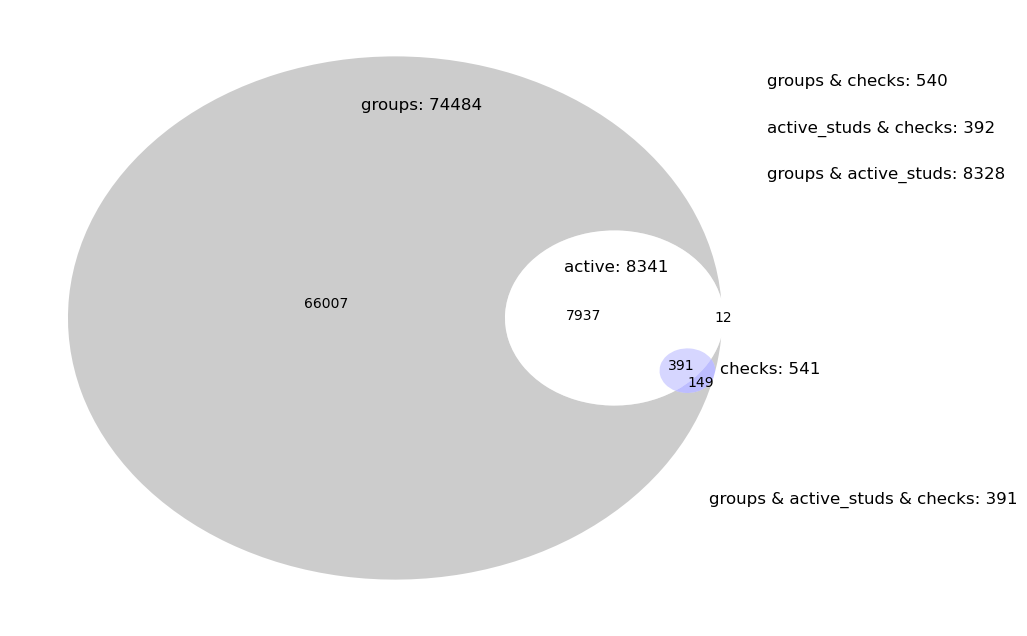

In [10]:
# создам множество уникальных значений student_id для каждого датасета
set_groups = set(groups['student_id'])
set_active = set(active_studs['student_id'])
set_checks = set(checks['student_id'])

# вычислю количество студентов в каждом датасете и их пересечениях
n_groups = len(set_groups)
n_active = len(set_active)
n_checks = len(set_checks)
n_ga = len(set_groups & set_active)
n_gc = len(set_groups & set_checks)
n_ac = len(set_active & set_checks)
n_gac = len(set_groups & set_active & set_checks)

# строю диаграмму Эйлера-Венна с присваиванием цветов кругам и контролем размера диаграммы
fig, ax = plt.subplots(figsize=(12, 8))
venn3(subsets=(n_groups - n_ga - n_gc + n_gac, n_active - n_ga - n_ac + n_gac, n_ga - n_gac, \
               n_checks - n_gc - n_ac + n_gac, n_gc - n_gac, n_ac - n_gac, n_gac),
      set_labels=('', '', ''),
      set_colors=('gray', 'white', 'blue'))

# добавляю подписи для каждого множества и их пересечений, регулирую их положение на графике
ax.text(-0.1, 0.45, f'groups: {n_groups}', fontsize=12)
ax.text(0.25, 0.1, f'active: {n_active}', fontsize=12)
ax.text(0.52, -0.12, f'checks: {n_checks}', fontsize=12)
ax.text(0.6, 0.3, f'groups & active_studs: {n_ga}', fontsize=12)
ax.text(0.6, 0.5, f'groups & checks: {n_gc}', fontsize=12)
ax.text(0.6, 0.4, f'active_studs & checks: {n_ac}', fontsize=12)
if n_gac > 0:
    ax.text(0.5, -0.4, f'groups & active_studs & checks: {n_gac}', fontsize=12)

# устанавлю соотношение масштабов для осей X и Y
ax.set_aspect(0.8)

# рисую вывод диаграммы
plt.show()

<a id='venn'></a>
Цифры на диаграмме совпадают с ранее полученными на описательной статистике, значит все выгружено корректно. Отдельными цифрами на диаграмме показана разница между количеством студентов в группе за вычетом иных входящих в нее групп (наложенных кругов). Также, видны 13 студентов за пределами group (12 active + 1 checks).

Благодаря диаграмме Эйлера-Венна я могу сделать еще больше выводов по нашей аудитории:

- количество активных студентов мало, а оплативших очень мало, по сравнению с общим числом студентов;
- не все оплатившие студенты входят в группу активных - 149 из 541 не входит, т.е. это студенты которые не видели наше обновление на сайте. Это может быть: автоматическая оплата; ошибочная оплата; или студенты решили приобрести какой-либо курс во время проведения эксперимента, не заходя на сайт. А еще это может быть ошибка логирования - id пользователей просто не были переведены в категорию active_studs, т. е. эти 149 человек могли все-таки быть активными (эта гипотеза обусловлена количеством этих студентов - на первый взгляд, их слишком много для автоматических или ошибочных оплат);
- студенты распределены по группам (все/активные/платящие) неравномерно.

*Примечание! Наличие указанных оплативших (но не активных) 149 пользователей не является, по моему мнению, основанием для прекращения эксперимента - это лишь гипотеза, подтвердить/опровергнуть, которую я не могу по имеющимся данным - это может быть, как ошибка логирования, так и автоматические оплаты, а может быть даже совокупность этих факторов (ни один из вариантов сейчас исключить нельзя). Поэтому данный аспект необходимо перепроверить, после чего прислать мне обновленные данные (если ошибка подтвердится), для пересчета метрик.*

*Так или иначе, пока у меня нет оснований считать, что эти 149 пользователей видели изменения на сайте и сознательно произвели оплату после этого.*

**Вывод!**

Для проведения А/Б теста по новой механике оплаты необходимо отобрать только активных пользователей, так как только они (**безусловно**) видели изменения на сайте и именно их оплаты являются не случайными. Для этого нужно подготовить данные, включающие пользователей, которые заходили в период эксперимента на сайт и входят в тестовую и контрольную группы. Также, из-за разницы между количеством платящих пользователей и активных платящих, будут участвовать только платящие, которые одновременно являются и активными.

Итого: 8 328 студентов будут учтены в А/Б тесте (8 341 активных - 13 которым не присвоена группа эксперимента).

In [11]:
def get_merge_studs(groups, active_studs, checks):
    """
    Функция объединяет датасеты (groups, active_studs, checks) по столбцу student_id
        и выводит описательную статистику по студентам, разделенным на две группы A и B.
    
    Args:
    :param groups: pandas.DataFrame, таблица с данными о группах студентов
    :param active_studs: pandas.DataFrame, таблица со списком активных студентов
    :param checks: pandas.DataFrame, таблица с данными об оплатах студентов
    
    Returns:
    pandas.DataFrame 
        Таблица с данными о студентах, принадлежащих группам A и B, с информацией об оплатах. 
        Столбцы: `student_id - id студента`, `grp` - группа студента, `rev` - сумма оплаты.
    """
    # объединяю три датасета по столбцу student_id
    final = active_studs.merge(groups, on='student_id', how='left')
    final = final.merge(checks, on='student_id', how='left')
    
    # заменяю пропущенные значения нулями
    final.fillna(0, inplace=True)
    
    # фильтрую по группам A и B
    final = final.query("grp == 'A' or grp == 'B'")
    
    # считаю статистику по интересующим меня вопросам
    n_total = len(final)
    n_group_a = len(final[final['grp'] == 'A'])
    n_group_b = len(final[final['grp'] == 'B'])
    pct_group_a = n_group_a / n_total * 100
    pct_group_b = n_group_b / n_total * 100    
    n_paid = len(final[final['rev'] > 0])
    n_not_paid = len(final[final['rev'] == 0])
    pct_paid = n_paid / n_total * 100
    pct_not_paid = n_not_paid / n_total * 100 
    total_rev_group_a = final[final['grp'] == 'A']['rev'].sum()
    total_rev_group_b = final[final['grp'] == 'B']['rev'].sum()
    mean_rev_group_a = final[final['grp'] == 'A']['rev'].mean()
    mean_rev_group_b = final[final['grp'] == 'B']['rev'].mean()
    min_rev_group_a = final.query("grp == 'A' and rev > 0")['rev'].min()
    min_rev_group_b = final.query("grp == 'B' and rev > 0")['rev'].min()
    max_rev_group_a = final[final['grp'] == 'A']['rev'].max()
    max_rev_group_b = final[final['grp'] == 'B']['rev'].max()
    paid_group_a = final.query("grp == 'A' and rev > 0")['rev'].count()
    paid_group_b = final.query("grp == 'B' and rev > 0")['rev'].count()
    pct_paid_group_a = paid_group_a / n_group_a * 100
    pct_paid_group_b = paid_group_b / n_group_b * 100
    
    # готовлю строки форматирования для вывода процентов
    pct_group_a_str = '{:.2f}%'.format(pct_group_a)
    pct_group_b_str = '{:.2f}%'.format(pct_group_b)
    pct_paid_str = '{:.2f}%'.format(pct_paid)
    pct_not_paid_str = '{:.2f}%'.format(pct_not_paid)
    
    # сохраняю результат в переменную final
    final = pd.DataFrame({
        'student_id': final['student_id'],
        'grp': final['grp'],
        'rev': final['rev']
    })
    
    # вывожу описательную статистику по произведенным расчетам с форматированием
    print('Total rows:', n_total)
    print('Students in Group A: {} ({})'.format(n_group_a, pct_group_a_str))
    print('Students in Group B: {} ({})'.format(n_group_b, pct_group_b_str))
    print('Paid students: {} ({})'.format(n_paid, pct_paid_str))
    print('Not paid students: {} ({})'.format(n_not_paid, pct_not_paid_str))
    print('Number of paid students in Group A: {} ({:.2f}% of all Group A students)'.format(paid_group_a, pct_paid_group_a))
    print('Number of paid students in Group B: {} ({:.2f}% of all Group B students)'.format(paid_group_b, pct_paid_group_b))
    print('Total revenue from Group A: {:.2f}'.format(total_rev_group_a))
    print('Total revenue from Group B: {:.2f}'.format(total_rev_group_b))
    print('Minimum revenue for Group A: {:.2f}'.format(min_rev_group_a))
    print('Minimum revenue for Group B: {:.2f}'.format(min_rev_group_b))
    print('Mean revenue for Group A: {:.2f}'.format(mean_rev_group_a))
    print('Mean revenue for Group B: {:.2f}'.format(mean_rev_group_b))
    print('Maximum revenue for Group A: {:.2f}'.format(max_rev_group_a))
    print('Maximum revenue for Group B: {:.2f}'.format(max_rev_group_b))
    
    return final

In [12]:
# сохраню результат функции get_merge_studs в переменную и выведу показатели
final = get_merge_studs(groups, active_studs, checks)

Total rows: 8328
Students in Group A: 1535 (18.43%)
Students in Group B: 6793 (81.57%)
Paid students: 391 (4.70%)
Not paid students: 7937 (95.30%)
Number of paid students in Group A: 78 (5.08% of all Group A students)
Number of paid students in Group B: 313 (4.61% of all Group B students)
Total revenue from Group A: 72820.00
Total revenue from Group B: 393074.00
Minimum revenue for Group A: 199.00
Minimum revenue for Group B: 199.00
Mean revenue for Group A: 47.44
Mean revenue for Group B: 57.86
Maximum revenue for Group A: 3660.00
Maximum revenue for Group B: 4650.00


In [13]:
# проверю сохранение сводного датасета и структуру данных
final.head(3)

,student_id,grp,rev
0,581585,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0


Подведу краткий промежуточный итог по очередным полученным значениям.

Общее число студентов, число оплативших студентов совпадают с ранее показанными мной данными.

Примечательно, что при разности количества студентов в группах А и Б, количество оплативших студентов примерно равно (по отношению к составу группы) - около 5% для каждой из групп. Ровно те же 5% от всех активных студентов оплатили курсы (уже в обоих группах). Таким образом, прослеживается общая динамика в количестве оплативших студентов, что в группах, что в общем разрезе активных студентов.

Также, с учетом размеров средней оплаты и максимальных значений оплаты в обеих группах, очевидно, что в наличии есть **выбросы**. Более детально я на это посмотрю на следующем шаге - _визуализации_ имеющихся данных.

In [14]:
def get_visualize(final):
    """
    Функция отображает графики, описывающие данные о студентах и их платежах,
        с помощью matplotlib.pyplot, seaborn, scipy.stats:
    countplot (распределение активных студентов по группам A/Б)
    histplot (распределение оплативших студентов по группам A/Б)
    boxplots (оплатившие студенты по группам: активные и нет)
    probplots (QQ-plot для оплативших активных студентов по группам A/Б)
    
    Args:
    :param final: pandas.DataFrame - информация о студентах и их платежах, по которой строится визуализация
    
    Returns:
    -------
    ничего не возвращает, но выводит графики на экран
    """
    # создаю фигуру с 2 столбцами и 3 рядами, в которой размещу графики
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 25))
    
    # первый график - распределение активных студентов групп A и B
    sns.countplot(x='grp', data=final, ax=axs[0, 0], palette=['lightskyblue', 'dimgray'])
    axs[0, 0].set_xlabel('Group')
    axs[0, 0].set_ylabel('Count')
    axs[0, 0].set_title('Distribution of students by group')
    
    # второй график - распределение групп A и B по уплаченным суммам
    paid_users = final[final['rev'] > 0]
    sns.histplot(x='rev', data=paid_users, hue='grp', ax=axs[0, 1], palette=['lightskyblue', 'dimgray'], bins=15)
    axs[0, 1].set_xlabel('Revenue')
    axs[0, 1].set_ylabel('Count')
    axs[0, 1].set_title('Distribution of paid students by group')
    
    # третий график - выбросы по оплатившим активным студентам групп A и B
    sns.boxplot(x='grp', y='rev', data=paid_users, ax=axs[1, 0], palette=['lightskyblue', 'dimgray'])
    axs[1, 0].set_xlabel('Group')
    axs[1, 0].set_ylabel('Revenue')
    axs[1, 0].set_title('Boxplot of revenue by active groups')
    
    # фильтрую оплативших студентов, которых нет в active_studs, но которые относятся к группам A или B
    inactive_paid_students = checks[(checks['rev'] > 0) & ~checks['student_id'].isin(active_studs['student_id'])]
    inactive_paid_students = inactive_paid_students.merge(groups, on='student_id', how='inner')
    inactive_paid_students = inactive_paid_students[inactive_paid_students['grp'].isin(['A', 'B'])]

    #  четвертый график - выбросы по оплатившим неактивным студентам групп A и B
    sns.boxplot(x='grp', y='rev', data=inactive_paid_students, ax=axs[1, 1], palette=['lightskyblue', 'dimgray'], \
                order=['A', 'B'])
    axs[1, 1].set_xlabel('Group')
    axs[1, 1].set_ylabel('Revenue')
    axs[1, 1].set_title('Boxplot of revenue by inactive groups')
    
    # пятый график - qq-plot для группы A, для проверки нормальности распределения
    stats.probplot(paid_users[paid_users['grp'] == 'A']['rev'], dist="norm", plot=axs[2, 0])
    axs[2, 0].get_lines()[0].set_markerfacecolor('lightskyblue')
    axs[2, 0].get_lines()[0].set_color('lightskyblue')
    axs[2, 0].get_lines()[1].set_color('gray')
    axs[2, 0].set_title('QQ-plot of paid students in Group A')
    
    # шестой график - qq-plot для группы B, для проверки нормальности распределения
    stats.probplot(paid_users[paid_users['grp'] == 'B']['rev'], dist="norm", plot=axs[2, 1])
    axs[2, 1].get_lines()[0].set_color('lightskyblue')
    axs[2, 1].get_lines()[1].set_color('gray')
    axs[2, 1].set_title('QQ-plot of paid students in Group B')
    
    # сохраняю результат и показываю графики
    plt.tight_layout()
    plt.show()

<a id='viz'></a>

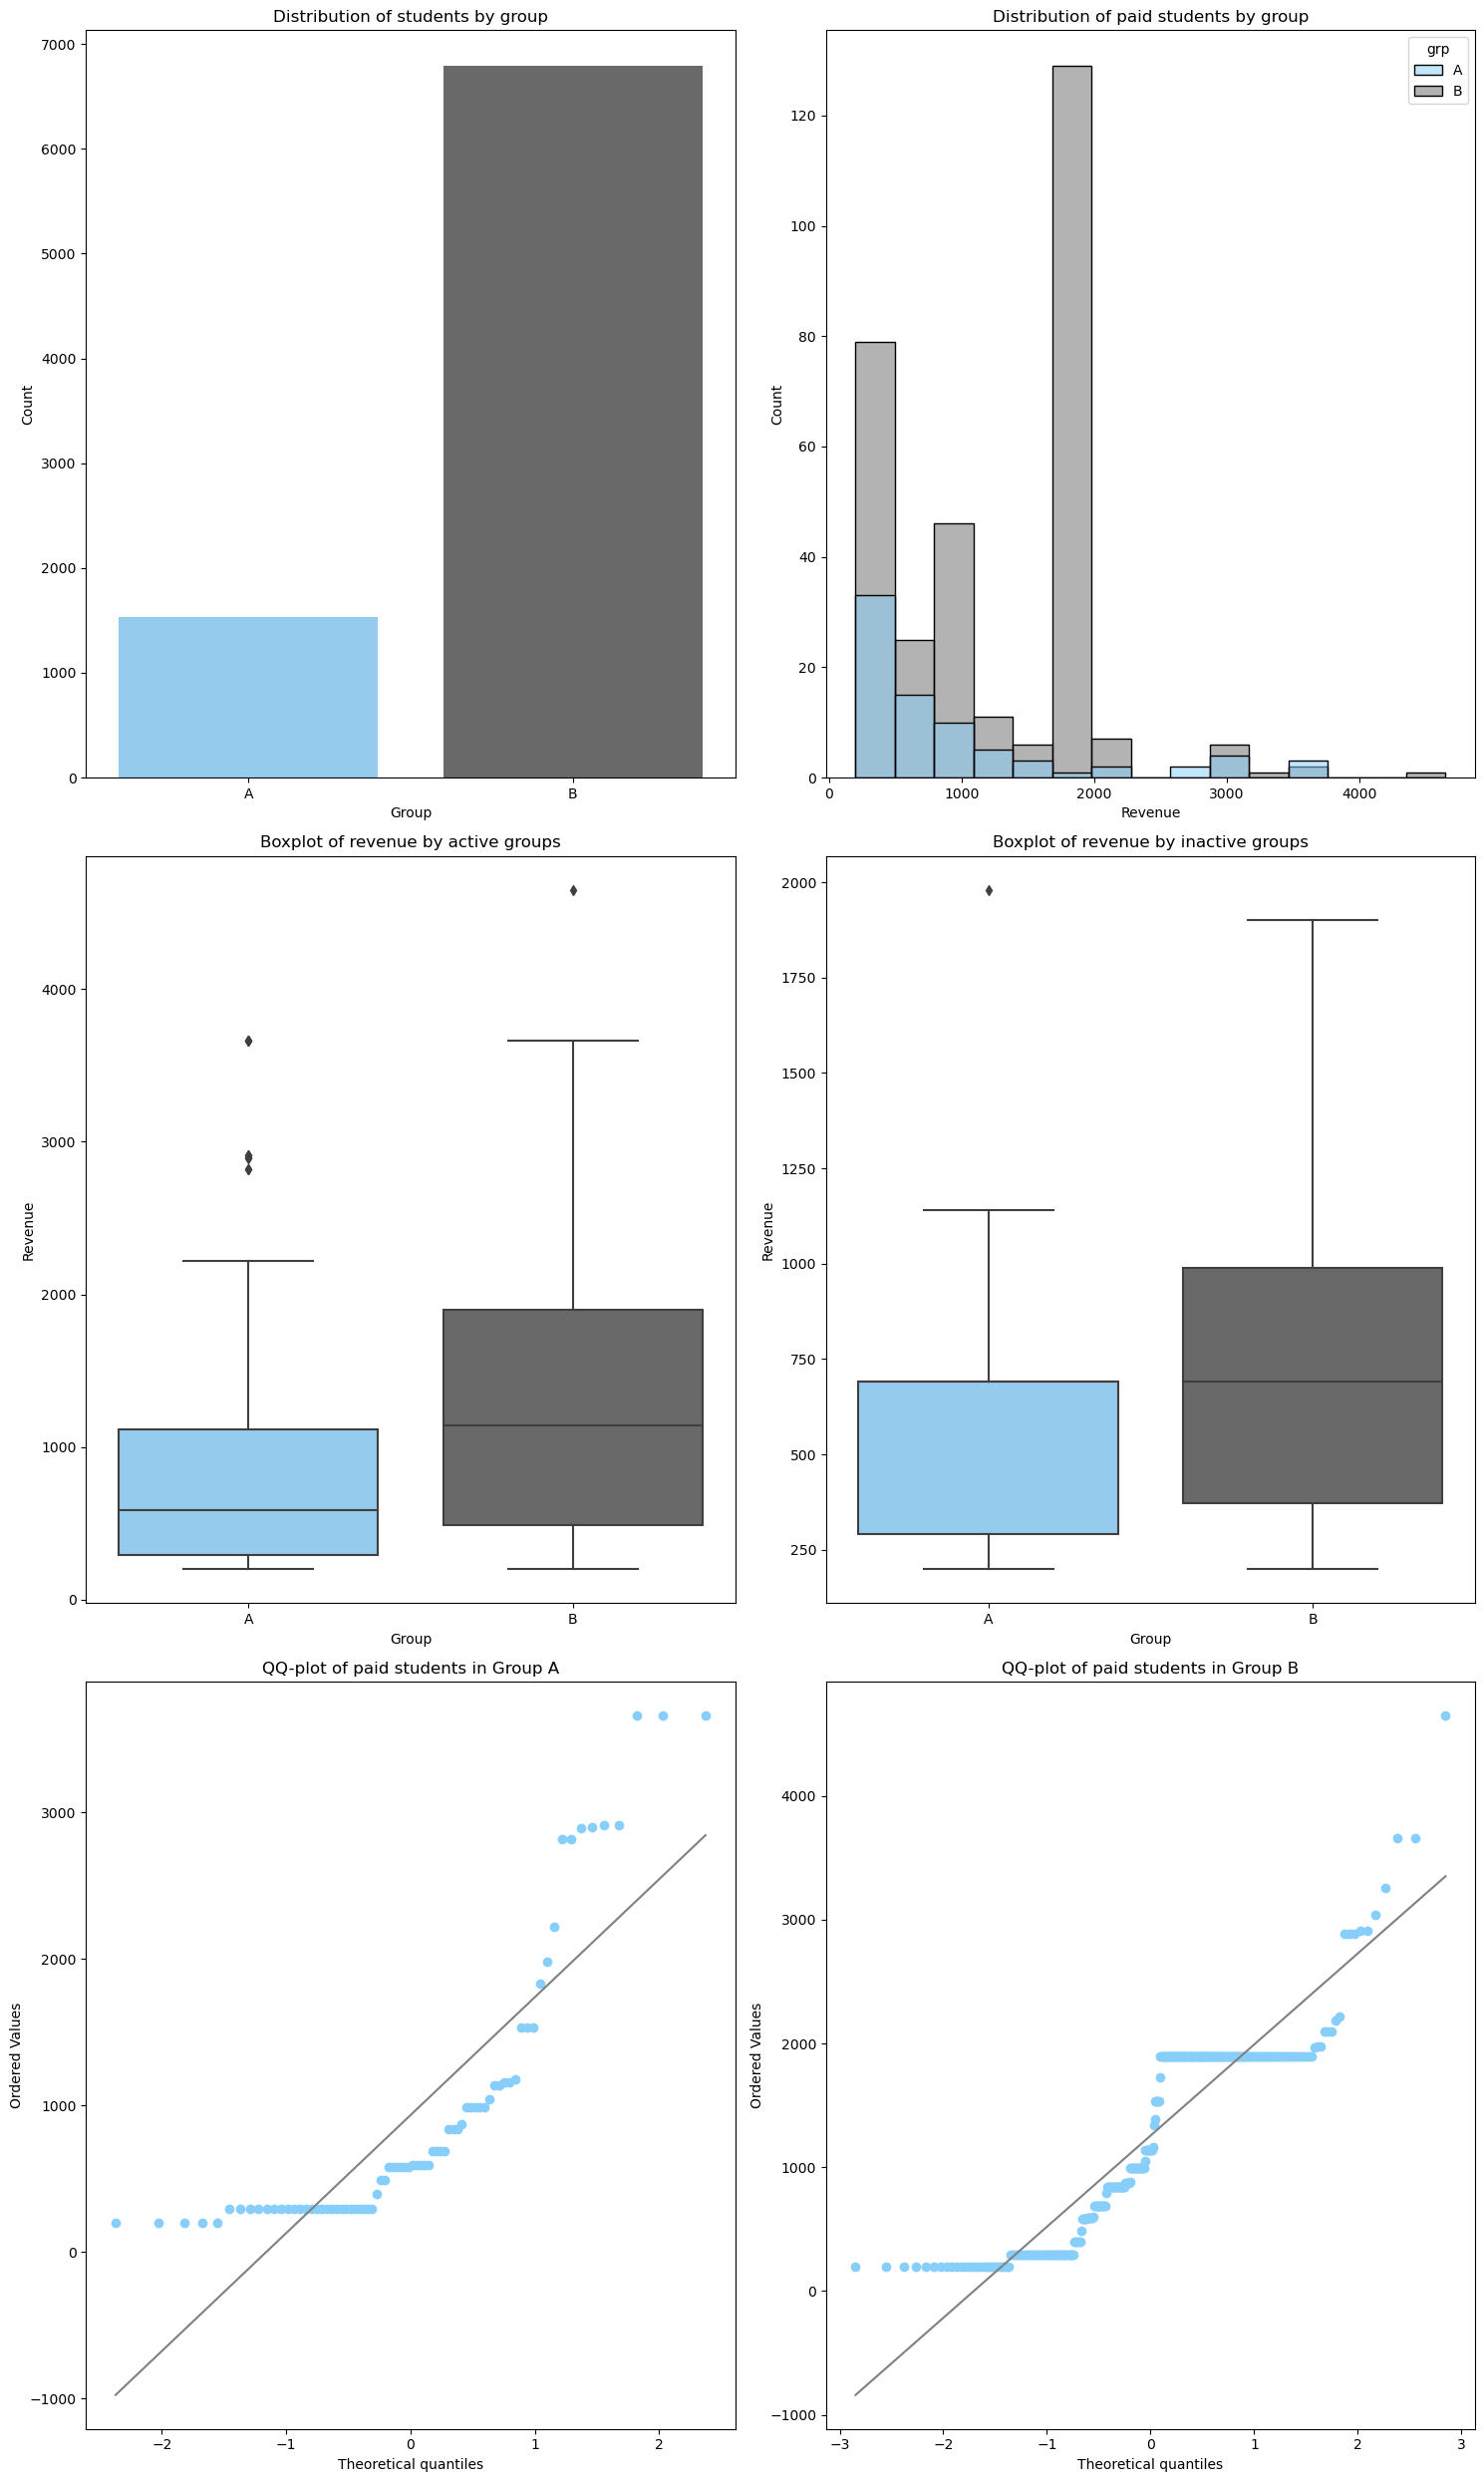

In [15]:
# вызываю функцию для вывода получившихся графиков
get_visualize(final)

<a id='conclusion'></a>
#### Что показывают графики?

**1. Гистограмма - Distribution of paid students by group (график 2) сообщает мне следующие сведения:**

- очевидная _ненормальность_ распределений платящих пользователей по обеим группам;

- группа Б отличается от группы А только по линиям 100, 1000 и _особенно 1900_. То есть в тестовой группе значительно больше платящих пользователей, в первую очередь, на отметке 1900, что однозначно должно повлиять на метрики. Получается, что самый популярный чек для группы Б, приблизительно, 1900 - это главное отличие между группами. Это необычно. Как можно это объяснить? Это могла быть акция, которая была направлена на продвижение данной покупки (скидка с данной суммы, скидка на определенный курс с этой стоимостью и т.д.).


**2. группа Б значительно больше группы A (график 1 - countplot). Это странно, т.к. обычно перевес бывает в пользу контрольной группы (А). Я считаю, что причинами такого дисбаланса между группами, в данном случае, могут быть:**

- _непредвиденный фактор_ - например, повышенный интерес к новой системе оплаты или определенному курсу по акции у пользователей (особенно при успешном маркетинге), что привело к большему количеству пользователей в группе Б (особенно по линии 1900). Но если это так, то в целом такая ситуация может значимо повлиять на эксперимент (ведь я оцениваю новую систему оплаты, а не эффективность акции по определенному курсу). В таком случае следует повторить эксперимент без влияния такой акции, которая по факту скрадывает результаты эксперимента -  так как я не смогу определить, какой именно фактор повлиял на результат;

- _ошибка_ в настройках эксперимента, которая привела к неравномерному распределению пользователей. Мы проводим эксперимент по оценке эффективности новой механики оплаты - то есть это действие пользователя, совершенное после захода на сайт, выбора продукта и перехода к экрану оплаты. Но описательная статистика, которую я выводил ранее, говорит об обратном. Так, получается, что система сплитования вызывает вопросы: студентов в группе Б ~82% от всех активных (против ~18% в А), а оплативших в группе Б только ~5% от данной группы. Получается у нас гигантский перевес группы Б, который почти не зависит от оплаты продукта, а значит от новой фичи по механике оплаты, что как раз может быть вызвано неверным сплитованием:

_Students in Group A: 1535 (18.43%)_  
_Students in Group B: 6793 (81.57%)_  
_Number of paid students in Group A: 78 (5.08% of all Group A students)_  
_Number of paid students in Group B: 313 (4.61% of all Group B students)_


Чтобы принять окончательное решение о внедрении новой системы оплаты для всех пользователей по результатам эксперимента, следует, в связи с изложенным выше, дополнительно оценить, насколько статистическая значимость изменений по группе Б сильно зависит от дисбаланса между группами. Если это существенный фактор, рекомендуется провести еще один А/Б тест с более равномерным распределением пользователей.

Указанную оценку статистической значимости в связи с дисбалансом можно провести следующим образом:
- проверить, были ли пользователи случайным образом назначены в группы A и Б. Если пользователи были назначены в группы не случайным образом, то дисбаланс может привести к искажению результатов теста;

- проверить, являются ли группы А и Б сравнимыми по характеристикам пользователей. Например, если группа Б содержит значительно больше новых пользователей (зарегистрированных именно при введении экспериментальной оплаты), чем группа А, то это может повлиять на статистическую значимость результатов теста;

- проверить на каком этапе захода пользователя на сайт (или до этого момента) проводилось сплитование, повлияло ли это на то, что у нас в группе Б появилось такое большое количество пользователей - если это так, то нужно изменить подход к сплитованию - разделять пользователей случайным образом до момента захода на сайт или непосредственно во время захода равномерным образом;

- провести анализ дополнительных параметров, таких как средний возраст пользователей, пол, уровень образования, географическое расположение и т.д. Если группы А и Б значительно отличаются по каким-либо параметрам, то это также может оказать влияние на результаты теста.

*Примечание! Опять же в настоящее время это не является причиной остановки эксперимента, т.к. по имеющимся данным я не могу установить, какая из указанных причин выше повлияла на дисбаланс групп - это повод провести дополнительные исследования (в целях устранения рисков недостоверности результатов эксперимента), для которых сейчас у меня недостаточно данных. Однако, об этом обязательно нужно указать в выводах.*


**3. распределения в обеих группах _ненормальны_ (QQ-plots и график 2 - histplot), а также имеются _выбросы_ (график 3 - boxplot).**

В таком случае статистические тесты, которые используют параметрические модели, могут быть неприменимы или давать неточные результаты. Поэтому для оценки метрик я буду ориентироваться на непараметрические тесты.

**4. Глядя на "Boxplot of revenue by active groups" я могу сделать следующие выводы:**

- **выбросы**: данные имеют выбросы (экстремальные значения) - они представляют собой значения, которые сильно отличаются от большинства других наблюдений;
- **медианы**: медиана группы Б значительно выше медианы группы А. Это говорит о том, что пользователи из группы Б приносят более высокий доход по сравнению с пользователями из группы А. Верхняя граница ящика группы А совпадает с медианой группы Б - это говорит о том, что 75% пользователей из группы А приносят доход, меньший или равный медианному доходу пользователей из группы Б (результат оплат с чеком 1900);
- **ассиметрия**: положение медианы в ящике (особенно группы А), а также то, что один ус длиннее другого говорят об ассиметрии данных (ненормальности их распределения), в том числе по причине экстремальных значений (особенно по группе Б). Опять же это говорит в пользу использования непараметрических методов.

*Примечание! Оснований к исключению выбросов у меня нет, т.к. они могут быть не случайны, а определить их случайность я не могу, т.к. у меня нет ретроданных для проверки. Поэтому статистические тесты буду проводить по имеющимся данным. Но это дополнительный повод также проверить данные на ошибки до принятия окончательного решения по итогам эксперимента.*

###### Что буду делать дальше?

Необходимо проверить по имеющимся данным разность метрик по группам А/Б на статистическую значимость, поскольку есть только непроверенные гипотезы об ошибках в данных. Это, в том числе, необходимо, чтобы впоследствии (если будут обнаружены ошибки в первоначальных данных или мне будут представлены новые данные) сравнить изменения с результатами по текущим данным.

Метрики, которые я считаю следует выбрать в данном случае для анализа А/Б тестирования, включают CR, ARPU и ARPPU.
**CR** может отражать удобность новой механики оплаты для студентов. Эта метрика важна для бизнеса, так как она показывает эффективность работы сайта, его юзабилити и может помочь в определении проблем, которые мешают пользователям совершить желаемое действие - совершить оплату.
**ARPU** и **ARPPU** являются важными показателями для бизнеса, в части показателя увеличения доходности и могут помочь определить эффективность монетизации продукта.

Посчитанные метрики **ARPU** и **ARPPU** я буду проверять на статистическую значимость посредством _бутстрапа_ со средним, как мерой центральной тенденции - использование среднего будет более наглядно и чувствительно к различиям в данном случае, чем медиана. Также увеличу количество подвыборок бутстрапа до 5 000, т.к. количество оплативших студентов у нас крайне невелико, что в теории должно увеличить точность теста. 

Выбирая из непараметрических тестов, я предпочитаю бутстрап, так как он более точен и надежен, чем U-тест. Это связано с тем, что бутстрап использует метод случайных повторов, который позволяет оценить распределение выборки без предположения о ее распределении. В отличие от U-теста, бутстрап позволяет получить более точную оценку p-value, особенно при малых выборках. Бутстрап является непараметрическим методом, который не требует никаких предположений о распределении выборки. U-тест же предполагает, что распределение данных схоже в обеих группах (чего в данном случае, судя по графикам, не наблюдается). Кроме того результаты U-теста сложно интерпретировать бизнесу.

Метрику **CR**, поскольку она является бинарной категориальной переменной, проверю критерием _Хи-квадрат_. Ведь данные по метрике CR у меня в виде двух категорий: 1 - оплатил / 0 - не оплатил.
Также, т.к. выборки достаточно большие (1535 в группе А и 6793 в группе Б), я могу использовать критерий Хи-квадрат для определения статистической значимости различий между двумя этими группами. Критерий Хи-квадрат подходит для таких данных, потому что он использует наблюдаемые и ожидаемые частоты в каждой ячейке таблицы сопряженности, чтобы определить, насколько значима связь между переменными.

###### Как буду считать метрики?

1. **CR** (конверсия онлайн платежей) - отношение количества оплативших клиентов к общему числу активных клиентов:

- CR = (количество оплативших клиентов / общее количество активных клиентов) * 100%

2. **ARPU** (средняя выручка на одного активного пользователя) - отношение общей суммы выручки к общему числу активных пользователей:

- ARPU = общая сумма выручки / общее число активных пользователей

3. **ARPPU** (средняя выручка на одного платящего пользователя) - отношение общей суммы выручки к общему числу платящих пользователей:

- ARPPU = общая сумма выручки / общее число платящих пользователей

In [87]:
def get_metrics(final):
    """
    Функция вычисляет CR, ARPU и ARPPU для каждой из групп (A и B)
    
    Args:
    :param final: pandas.DataFrame - данные о выручке, количестве 
            уникальных студентов и группах
    Returns:
    -------
    pd.DataFrame: pandas.DataFrame со сводными результатами вычисления метрик CR, 
            ARPU и ARPPU для каждой группы, а также их визуализация.
    """
    # считаю CR по формуле
    cr_a = round(final[final['grp'] == 'A']['rev'].astype(bool).sum() / final[final['grp'] == 'A']['rev'].count() * 100, 2)
    cr_b = round(final[final['grp'] == 'B']['rev'].astype(bool).sum() / final[final['grp'] == 'B']['rev'].count() * 100, 2)

    # считаю ARPU по формуле
    arpu_a = round(final[final['grp'] == 'A']['rev'].sum() / final[final['grp'] == 'A']['student_id'].nunique(), 2)
    arpu_b = round(final[final['grp'] == 'B']['rev'].sum() / final[final['grp'] == 'B']['student_id'].nunique(), 2)

    # считаю ARPPU по формуле
    arppu_a = round(final[final['grp'] == 'A']['rev'].sum() / final[final['grp'] == 'A']['rev'].astype(bool).sum(), 2)
    arppu_b = round(final[final['grp'] == 'B']['rev'].sum() / final[final['grp'] == 'B']['rev'].astype(bool).sum(), 2)

    # создаю результирующий датасет с посчитанными метриками для групп
    summary = pd.DataFrame({
        'group': ['A', 'B'],
        'CR': [cr_a, cr_b],
        'ARPU': [arpu_a, arpu_b],
        'ARPPU': [arppu_a, arppu_b]
    })
    
    # вывожу визуализацию данных по посчитанным метрикам
    summary.set_index('group', inplace=True)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    colors = {'A': 'lightskyblue', 'B': 'gray'}
    for idx, metric in enumerate(['CR', 'ARPU', 'ARPPU']):
        summary[metric].plot(kind='bar', ax=axes[idx], rot=0, zorder=3, color=[colors[group] for group in summary.index])
        axes[idx].set_title(f'{metric} Comparison')
        if idx == 0:
            axes[idx].set_ylabel('Values')
        axes[idx].set_xlabel('Groups')
        if metric in ['ARPU', 'ARPPU']:
            axes[idx].spines['right'].set_visible(False)
            axes[idx].spines['top'].set_visible(False)
        axes[idx].grid(axis='y', linestyle='--', zorder=0)
        axes[idx].set_axisbelow(True)

    plt.tight_layout()
    plt.show()

    return summary.reset_index()

<a id='metrics'></a>

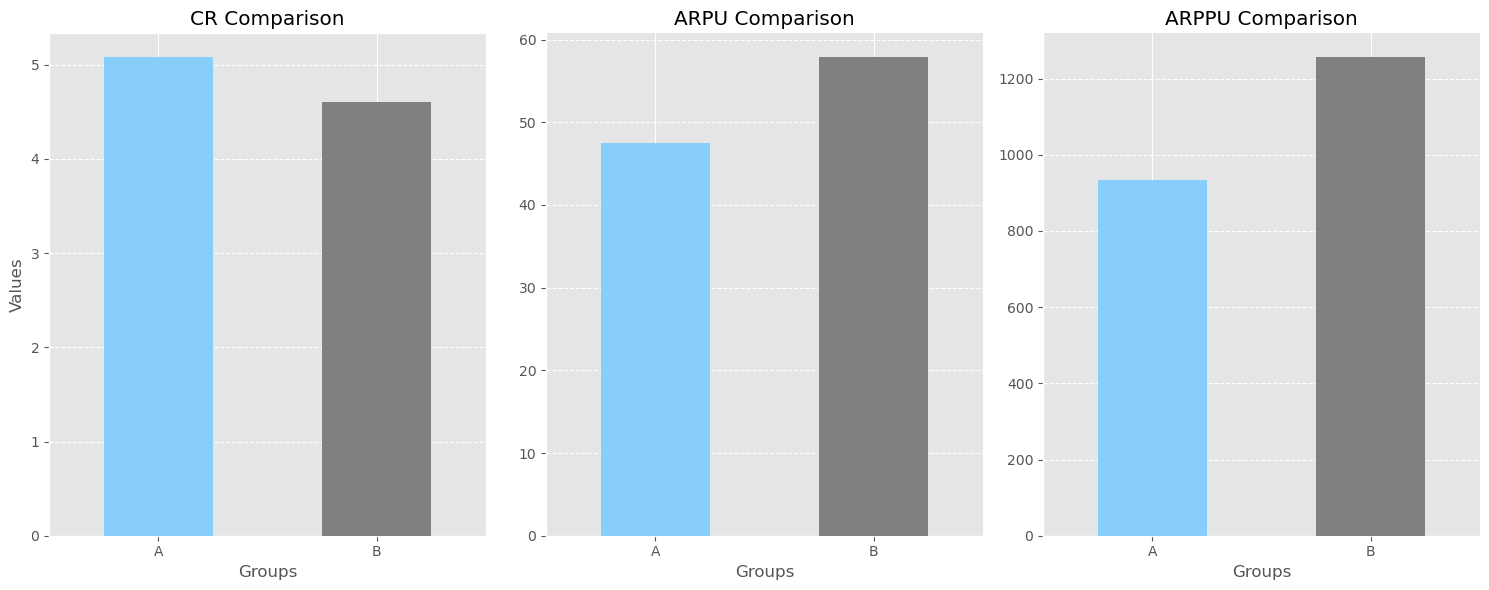

,group,CR,ARPU,ARPPU
0,A,5.08,47.44,933.59
1,B,4.61,57.86,1255.83


In [88]:
# вызову функцию для анализа выбранных метрик по группам
get_metrics(final)

###### Предварительные выводы до проведения статистических тестов

- **CR** (Conversion Rate) уменьшился в целевой группе в сравнении с контрольной, что может указывать на то, что часть пользователей перестала платить. Отрицательный эффект CR может быть связан с отсечением части пользователей, которые платили малые суммы, с одновременным увеличением среднего чека;
- **ARPU** (Average Revenue Per User) увеличился в целевой группе, что может указывать на то, что средний доход на одного пользователя вырос;
- **ARPPU** (Average Revenue Per Paying User) увеличился в целевой группе, что может указывать на то, что средний доход на одного платящего пользователя также вырос.

Увеличение ARPU и ARPPU связано с тем, что часть пользователей начала покупать более дорогие услуги (линия 1900 группы Б).
Итак, хотя CR снизился, ARPU и ARPPU выросли, что может указывать на то, что изменения, которые были внесены, имеют потенциал увеличения доходов компании в долгосрочной перспективе. Однако, снижение конверсии также может иметь отрицательный эффект на долгосрочную прибыльность, поэтому возможно потребуется дополнительный анализ и корректировка маркетинговых стратегий, чтобы балансировать между ростом доходов и сохранением конверсии.

Это прведварительные выводы о разнице в группах по посчитанным метрикам, которые необходимо проверить на статистическую значимость.

In [39]:
def get_bootstrap(
    data_column_1,                       # числовые значения первой (контрольной) выборки
    data_column_2,                       # числовые значения второй (тестовой) выборки
    boot_it   = 5000,                    # количество бутстрэп-подвыборок
    statistic = np.mean,                 # интересующая нас статистика - среднее
    bootstrap_conf_level = 0.95,         # уровень значимости - альфа 0,05
    graph         = True,                # отрисовывать ли график
    show_progress = False,               # показывать ли индикатор програсса
    metric_name='x'                      # название метрики для идентификации на графиках
    ):
    """
    Функция реализует метод бутстрэпа для подсчета доверительного 
        интервала и p-значения разности между двумя числовыми выборками
    
    Args:
    Подробно расписаны в комментариях к параметрам
    
    Returns:
    -------
    dict: Словарь, содержащий доверительный интервал и p-значение разности между двумя выборками данных.
    Ключи:
    - "ci": доверительный интервал в формате pandas.DataFrame, содержащий левую и правую границы интервала;
    - "p_value": p-значение для разности между двумя выборками данных.
    """
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
    # выбираю отрисовывать индикатор прогресса или нет
    if show_progress:
        progress_bar = tqdm
    else:
        progress_bar = lambda x: x
    
    for i in progress_bar(range(boot_it)):        # извлекаю подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True                        # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        samples_delta = samples_2 - samples_1       # нахожу разницу подвыборок
        boot_data.append(statistic(samples_delta))  # применяю статистику для разниц подвыборок
        
    pd_boot_data = pd.DataFrame(boot_data)

    # устанавливаю доверительный интервал 
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # отисовываю графики
    if graph == True:
        plt.hist(pd_boot_data[0], bins = 50, color='lightskyblue', edgecolor='gray')
        plt.style.use('ggplot')
        plt.vlines(ci, ymin=0, ymax=50, color='gray', linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title(f"Histogram of boot_data for {metric_name}")        
        plt.show()
    return {"ci": ci, 
            "p_value": p_value}

In [40]:
def get_cr_func(x):
    """
    CR - conversion rate
        Вычисляет долю случаев, когда произошло ожидаемое событие, 
        из общего числа случаев - конверсия в оплату.
        
    Args:
    Для корректной работы функции в качестве аргумента x необходимо передать
        серию со значениями 1 и 0, или True и False.
        
    Returns:
    float: доля случаев, когда произошло ожидаемое событие, 
        из общего числа случаев.
    """
    return sum(x) / len(x)

def get_arpu_func(x):
    """
    ARPU - average revenue per user
        Вычисляет среднюю выручку на одного пользователя, с учетом всех пользователей (в том числе не плативших).
        
    Args:
    Для корректной работы функции в качестве аргумента x необходимо передать
        серию, где все NaN-значения заменнены на нули.
        
    Returns:
    float: средняя выручка на одного пользователя, 
        с учетом всех пользователей (в том числе не плативших).
    """
    return np.mean(x)

def get_arppu_func(x):
    """
    ARPPU - average revenue per paying user
        Вычисляет среднюю выручку на одного платящего пользователя.
        
    Args:
    Для корректной работы функции в качестве аргумента y необходимо передать
        серию, где отобраны только платежи, т.е. отфильтрованы нули или вместо нулей стоят NaN.
        
    Returns:
    float: средняя выручка на одного платящего пользователя.
    """
    return np.mean(x)

In [48]:
def get_analyze_final(final):
    """
    Функция проводит анализ метрик между двумя группами A и B, а именно CR, ARPU, и ARPPU.

    Args:
    :final: pandas.DataFrame, содержащий данные о двух группах

    Returns:
    ничего не возвращает, но выводит графики и статистические расчеты на экран
    """
    # создаю промежуточные датасеты
    a_group = final[final.grp == 'A'].copy()
    a_group['payment'] = (a_group.rev > 0).astype(int)
    b_group = final[final.grp == 'B'].copy()
    b_group['payment'] = (b_group.rev > 0).astype(int)
    
    # проверяю метрики CR с помощью критерия Хи-квадрат
    crosstab = pd.crosstab(final.grp, final.rev > 0)
    chi2_stat, chi2_pvalue, _, _ = chi2_contingency(crosstab, correction=False)
    
    # рассчитываю доли пользователей, совершивших покупки, в каждой группе
    p_a = crosstab.loc['A', 1] / (crosstab.loc['A', 0] + crosstab.loc['A', 1])
    p_b = crosstab.loc['B', 1] / (crosstab.loc['B', 0] + crosstab.loc['B', 1])
    
    # рассчитываю стандартную ошибку
    se = np.sqrt(p_a * (1 - p_a) / (crosstab.loc['A', 0] + crosstab.loc['A', 1]) + \
                 p_b * (1 - p_b) / (crosstab.loc['B', 0] + crosstab.loc['B', 1]))
    
    # рассчитываю z-оценку для заданного уровня значимости (0.05)
    z_score = norm.ppf(1 - 0.05 / 2)
    
    # рассчитываю доверительный интервал
    diff = p_b - p_a
    ci_low, ci_high = diff - z_score * se, diff + z_score * se
    
    # добавлю разделительную линию, чтобы обозначить заголовок критерия Хи-квадрат
    print("-" * 80)
    print("Проверка метрик СR для групп А/Б критерием Хи-квадрат:\n\n")
    
    # вывожу статистические результаты для метрики CR
    print("Таблица сопряженности для теста Хи-квадрат:")
    print(crosstab)
    print("\nГипотезы:")
    print("H0: метрики CR в двух группах одинаковые")
    print("H1: метрики CR в двух группах различаются")
    print(f"Статистика Хи-квадрат: {chi2_stat}")
    print(f"p-value: {chi2_pvalue}")
    print(f"Доверительный интервал (критерий Хи-квадрат) для метрики CR: ({ci_low:.4f}, {ci_high:.4f})")
    if chi2_pvalue < 0.05:
        print("Гипотеза H0 отвергается в пользу альтернативной гипотезы H1\n")
    else:
        print("Гипотеза H0 не отвергается\n")
        
    # добавлю разделительную линию, чтобы обозначить заголовок Бутстрапа для метрик ARPU и ARPPU
    print("-" * 80)
    print("Проверка метрик ARPU и ARPPU для групп А/Б бутстрапом:\n\n")

    # рисую график и вывожу статистические результаты для метрики ARPU
    a_group['rev'] = a_group['rev'].fillna(0)
    b_group['rev'] = b_group['rev'].fillna(0)
    arpu_results = get_bootstrap(a_group.rev, b_group.rev, statistic = get_arpu_func, metric_name='ARPU')
    print("Гипотезы:")
    print("H0: метрики ARPU в двух группах одинаковые")
    print("H1: метрики ARPU в двух группах различаются")
    print(f"Доверительный интервал: {arpu_results['ci'].values}")
    print(f"p-value: {arpu_results['p_value']}")
    if arpu_results['p_value'] < 0.05:
        print("Гипотеза H0 отвергается в пользу альтернативной гипотезы H1\n")
    else:
        print("Гипотеза H0 не отвергается\n")
        
    # рисую график и вывожу статистические результаты для метрики ARPPU
    a_group['payment'] = (a_group['rev'] > 0).astype(int)
    b_group['payment'] = (b_group['rev'] > 0).astype(int)
    arppu_results = get_bootstrap(a_group.rev[a_group.rev > 0], b_group.rev[b_group.rev > 0], \
                                  statistic = get_arppu_func, metric_name='ARPPU')
    print("Гипотезы:")
    print("H0: метрики ARPPU в двух группах одинаковые")
    print("H1: метрики ARPPU в двух группах различаются")
    print(f"Доверительный интервал: {arppu_results['ci'].values}")
    print(f"p-value: {arppu_results['p_value']}")
    if arppu_results['p_value'] < 0.05:
        print("Гипотеза H0 отвергается в пользу альтернативной гипотезы H1\n")
    else:
        print("Гипотеза H0 не отвергается\n")

<a id='stat'></a>

--------------------------------------------------------------------------------
Проверка метрик СR для групп А/Б критерием Хи-квадрат:


Таблица сопряженности для теста Хи-квадрат:
rev  False  True
grp             
A     1457    78
B     6480   313

Гипотезы:
H0: метрики CR в двух группах одинаковые
H1: метрики CR в двух группах различаются
Статистика Хи-квадрат: 0.6280206142073419
p-value: 0.4280822964525912
Доверительный интервал (критерий Хи-квадрат) для метрики CR: (-0.0168, 0.0073)
Гипотеза H0 не отвергается

--------------------------------------------------------------------------------
Проверка метрик ARPU и ARPPU для групп А/Б бутстрапом:




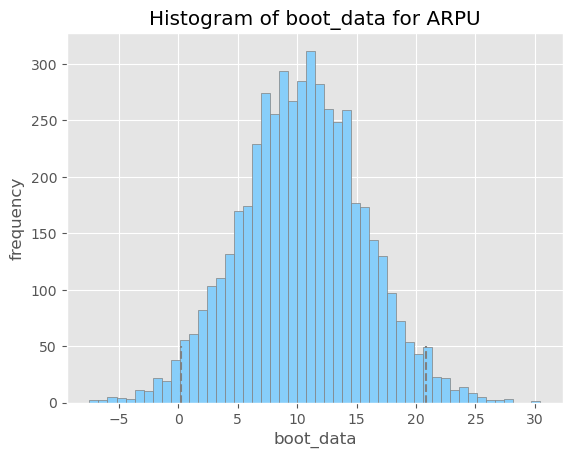

Гипотезы:
H0: метрики ARPU в двух группах одинаковые
H1: метрики ARPU в двух группах различаются
Доверительный интервал: [[ 0.22788217]
 [20.81098976]]
p-value: 0.044873803381597424
Гипотеза H0 отвергается в пользу альтернативной гипотезы H1



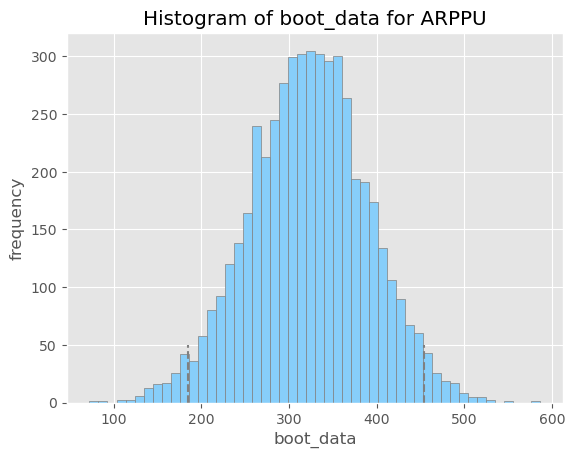

Гипотезы:
H0: метрики ARPPU в двух группах одинаковые
H1: метрики ARPPU в двух группах различаются
Доверительный интервал: [[185.29641683]
 [453.5973751 ]]
p-value: 1.7220801895182906e-06
Гипотеза H0 отвергается в пользу альтернативной гипотезы H1



In [49]:
# вызываю функцию, чтобы получить результаты статистических тестов
get_analyze_final(final)

<a id='result_1'></a>
### Выводы по первому заданию

**Оговорка по использованию результатов тестирования**.

При А/Б тестировании были выявлены аномалии, которые могут значимо влиять на результат эксперимента и нуждаются в дополнительной предварительной проверке и не могут быть уточнены по имеющимся данным, а именно:

1. 149 пользователей оплатили услуги, при этом не попали в категорию активных - автоматическая или ошибочная оплата или ошибка логирования. Если это подтвердится, то это значит результаты эксперимента искажены. Необходимо на новой итерации эксперимента исключить пользователей с автоматическими оплатами и/или исправить неверное логирование пользователей;

2. в тестовой группе Б значительное количество пользователей приобрели продукт с чеком 1900, что не может быть объяснено новой механикой оплаты, скорее всего это какая-либо акция, что также искажает результат эксперимента. Необходимо на новой итерации эксперимента исключить влияние продуктовых акций только на одну из групп;

3. система сплитования также вызывает вопросы в части следующего: студентов в группе Б ~82% от всех активных (против ~18% в А), а оплативших в группе Б только ~5% от данной группы. Установлен явный дисбаланс в разделении пользователей по группам, что также не может быть объяснено новой механикой оплаты.

**Вывод!** Рекомендую не использовать пока новую механику оплаты на всех пользователей, а проверить указанные выше ошибки, устранить их (если они подтвердятся), продолжить эксперимент, понаблюдать как изменятся метрики и статистическая значимость на новой итерации А/Б теста.

**Если же проверка указанных выше фактов не выявит ошибок, то справедливо следующее**.
Из результатов эксперимента и тестов следует, что новая механика оплаты приводит к статистически значимому приросту метрик ARPU и ARPPU. Рост метрик ARPU и ARPPU свидетельствует о росте доходности продукта.

Уменьшение же метрики CR не подтверждается статистической значимостью. Это значит, что новая механика оплаты может быть не настолько привлекательной для пользователей, чтобы стимулировать их совершать оплату чаще. Процент пользователей, совершивших оплату, не изменился статистически значимо между группами. Это повод подумать на будущее о том, как мы можем повлиять на эту метрику в новых экспериментах.

Таким образом, на основании проведенного исследования и совокупности полученных результатов можно рекомендовать использовать новую механику оплаты на всех пользователей.

---

[К содержанию](#contents)
<a id='sql_1'></a>

## Задание 2. SQL

### "Очень усердные ученики"
##### 2.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

Дана таблица default.peas:

| Название атрибута | Тип атрибута | Смысловое значение |
|-------------|-------------|-------------|
| st_id   | 	int   | ID ученика   |
| timest  | timestamp   | Время решения карточки  |
| correct   | bool  | Правильно ли решена горошина?  |
| subject  | text   | Дисциплина, в которой находится горошина  |

##### 2.1 Задание

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

##### 2.1 Решение

In [50]:
# создам переменную с параметрами подключения к clickhouse
connect_SQL = {'host': 'http://clickhouse.beslan.pro:8080',
    'database': 'default',
    'user': 'student',
    'password': 'dpo_python_2020'
}

Мне необходимо написать такой запрос в переводе на обычный язык.

Выбери все уникальные st_id из таблицы default.peas, для которых поле correct равно 1, месяц поля timest совпадает с текущим месяцем и число строк для каждого st_id не менее 20

In [51]:
# сохраню запрос в переменной для последующего использованияс подключением к clickhouse
query_peas = '''
SELECT st_id 
FROM default.peas 
WHERE correct = 1 
  AND toMonth(timest) = toMonth(NOW()) 
GROUP BY st_id 
HAVING count(*) >= 20
'''

In [52]:
# отправляю запрос в clickhouse
best_students = ph.read_clickhouse(query=query_peas, connection=connect_SQL)

In [53]:
best_students.head(5)

,st_id


Запрос ничего не вернул. Это странно. Проверю результат непосредственно в Python. Для чего сохраню в переменную default.peas из clickhouse.

Да, так делать безусловно не всегда стоит, но в данном случае я предварительно зашел в Tabix и убедился, что мы имеем дело не с миллионами строк, так что для Python проблем не будет обработать данный запрос. 

In [54]:
# пишу запрос на выгрузку всей таблицы default.peas из clickhouse и сохраняю в переменную
query_control_peas = '''
SELECT 
    st_id, 
    toUnixTimestamp(timest) AS timest, 
    correct, 
    subject 
FROM default.peas
'''

In [55]:
# для ускорения действий выполню сразу три команды:
# загружу таблицу, заменю формат в столбце timest на время, заменю текстовое значение id студента на int
control_peas = ph.read_clickhouse(query=query_control_peas, connection=connect_SQL)
control_peas['timest'] = control_peas['timest'].apply(lambda x: datetime.datetime.fromtimestamp(x))
control_peas['st_id'] = control_peas['st_id'].astype(int)

In [56]:
# контролирую результат - смотрю первые три строки
control_peas.head(3)

,st_id,timest,correct,subject
0,100379,2021-10-30 13:32:29,1,Theory of probability
1,100379,2021-10-30 14:11:19,0,Vizualization
2,100379,2021-10-30 15:54:22,1,Theory of probability


In [57]:
# проверю период, за который в таблице default.peas хранятся данные
min_date = control_peas['timest'].min()
max_date = control_peas['timest'].max()
print(f'Период данных: {min_date.strftime("%d.%m.%Y")} - {max_date.strftime("%d.%m.%Y")}')

Период данных: 30.10.2021 - 31.10.2021


<a id='result_sql_1'></a>
##### Вывод по задаче 2.1

Мой SQL запрос отработал корректно - в таблице default.peas отсутствуют данные за текущий месяц, поэтому вернулся пустой результат.

**Ответ**: в текущем месяце отсутствуют очень усердные студенты. Или же просто в базе данных не имеется сведений о текущем месяце.

---

<a id='sql_2'></a>
#### "Оптимизация воронки"
##### 2.2 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Дана таблицы: default.peas (см. выше в 2.1), default.studs:

| Название атрибута | Тип атрибута | Смысловое значение |
|-------------|-------------|-------------|
| st_id   | 	int   | ID ученика   |
| test_grp | text   |  Метка ученика в данном эксперименте  |

и default.final_project_check:

| Название атрибута | Тип атрибута | Смысловое значение |
|-------------|-------------|-------------|
| st_id   | 	int   | ID ученика   |
| sale_time | timestamp   |  Время покупки |
| money  | 	int   | Цена, по которой приобрели данный курс   |
| subject | text   |  Учебный предмет  |

##### 2.2 Задание

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
- ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

##### 2.2 Решение

Декомпозирую задачу. Для начала напишу формулы по которым мне нужно посчитать каждую метрику SQL-запросом:

**ARPU** = (общий доход от пользователей купивших полный доступ) / (общее число пользователей)

**ARPAU** = (общая выручка от пользователей купивших полный доступ) / (количество активных пользователей за период)

**CR** = (количество пользователей, купивших полный доступ) / (общее количество пользователей) * 100%

**CR активного пользователя в покупку** = (количество пользователей, купивших полный доступ) / (общее количество активных пользователей, которые выполнили необходимое количество задач) * 100%

**CR активного пользователя в покупку по дисциплине математика** = (количество пользователей, купивших полный доступ по математике) / (общее количество активных пользователей, которые выполнили необходимое количество задач по математике) * 100%

Поскольку запрос будет сложным, содержащим подзапросы, напишу сперва модель запроса на обычном языке (или на приближенном к нему), а потом буду переводить на синтаксис SQL. Вот примерно каким должен быть запрос:

ВЫБЕРИ:
- Группу студента в эксперименте (s.test_grp),
- ARPU (средний доход на пользователя): сумма доходов по всем студентам, деленная на количество уникальных студентов, округленная до 2-х знаков после запятой (так как это по сути деньги),
- ARPAU (средний доход на активного пользователя): сумма доходов только от активных студентов, деленная на количество уникальных активных студентов, округленная до 2-х знаков после запятой,
- CR (конверсия в оплату): количество купивших студентов, деленная на количество уникальных студентов, округленная до 2-х знаков после запятой (тут для лучшей читаемости),
- CR_active (конверсия в оплату активных студентов) - количество купивших активных студентов, деленная на количество уникальных активных студентов, округленный до 2-х знаков после запятой,
- CR_active_math (конверсия в оплату активных студентов по математике) - количество купивших активных студентов по математике, деленная на количество уникальных активных студентов по математике, округленный до 2-х знаков после запятой

ИЗ таблицы default.studs (с псевдонимом s)

СОЕДЕНИ (по st_id) с результатами подзапроса l (  
    ВЫБЕРИ столбцы  
    st_id,  
    active_stud (если студент ответил правильно на более чем 10 вопросов, то он считается активным (активный студент = 1, иначе = 0),  
    math_active_stud (если студент правильно ответил на 2 и более вопросов по математике, то он считается активным по математике (активный студент по математике = 1, иначе = 0)  
    ИЗ таблицы default.peas  
    СГРУППИРУЙ по st_id  
    )  
СОЕДЕНИ (по st_id) с результатами подзапроса r (  
    ВЫБЕРИ столбцы  
    st_id,  
    total_revenue (как сумму столбца money для каждого студента),  
    math_revenue (как сумму столбца money, но только для записей с предметом математика)  
    ИЗ default.final_project_check  
    СГРУППИРУЙ данные по st_id  
    )  
СГРУППИРУЙ результаты по столбцу s.test_grp.

Использую также в запросе два clickhouse метода:

1. _uniqExact_: агрегатная функция ClickHouse, которая возвращает точное количество уникальных значений в столбце или выражении;

2. _uniqExactIf_: агрегатная функция ClickHouse, которая возвращает точное количество уникальных значений в столбце или выражении, но только для строк, удовлетворяющих определенному условию.

In [58]:
# напишу запрос по написанному макету в синтаксисе SQL и запишу в переменную
funnel_opt_query = '''
SELECT
    s.test_grp,
    round(sum(r.total_revenue) / uniqExact(s.st_id), 2) as ARPU,
    round(sumIf(r.total_revenue, l.active_stud=1) / uniqExactIf(s.st_id, l.active_stud=1), 2) as ARPAU,
    round(100 * uniqExactIf(s.st_id, r.total_revenue > 0) / uniqExact(s.st_id), 2) as CR,
    round(100 * uniqExactIf(s.st_id, l.active_stud=1 and r.total_revenue>0) / uniqExactIf(s.st_id, l.active_stud=1), 2) as CR_active,
    round(100 * uniqExactIf(s.st_id, l.math_active_stud=1 and r.math_revenue>0) / uniqExactIf(s.st_id, l.math_active_stud=1), 2) as CR_active_math
FROM default.studs s
LEFT JOIN (
    SELECT
        st_id,
        if (sum(correct) > 10, 1, 0) as active_stud,
        if (sumIf(correct, subject='Math') >= 2, 1, 0) as math_active_stud
    FROM default.peas
    GROUP BY
        st_id
    ) l ON s.st_id = l.st_id
LEFT JOIN (
    SELECT
        st_id,
        sum(money) as total_revenue,
        sumIf(money, subject='Math') as math_revenue
    FROM default.final_project_check
    GROUP BY st_id
    ) r ON s.st_id = r.st_id
GROUP BY
    s.test_grp
'''

In [59]:
# использую сохраненный запрос, чтобы подключиться к clickhouse и получить результат
funnel_opt = ph.read_clickhouse(query=funnel_opt_query, connection=connect_SQL)

In [60]:
# выведу результат запроса
funnel_opt

,s.test_grp,ARPU,ARPAU,CR,CR_active,CR_active_math
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


<a id='result_sql_2'></a>
**Задание выполнено**.

Однако, как и в первом случае, я не уверен в его корректности. Для того чтобы в этом убедиться, хочу повторить все действия в Python.

Предварительно я также проверил в Tabix таблицы default.studs и default.final_project_check - они совсем маленькие, что позволяет спокойно все сделать только в Python и Jupiter Notebook.

In [61]:
# напишу запрос на выгрузку всей таблицы default.studs
query_control_studs = '''
SELECT 
    st_id, 
    test_grp
FROM default.studs
'''

In [62]:
# загружаю таблицу default.studs из clickhouse, перевожу st_id в int, вывожу результат для контроля
control_studs = ph.read_clickhouse(query=query_control_studs, connection=connect_SQL)
control_studs['st_id'] = control_studs['st_id'].astype(int)
control_studs.head(3)

,st_id,test_grp
0,100379,pilot
1,101432,control
2,104818,pilot


In [63]:
# напишу запрос на выгрузку всей таблицы default.final_project_check
query_final_project_check = '''
SELECT 
    st_id, 
    toUnixTimestamp(sale_time) AS sale_time,
    money, 
    subject 
FROM default.final_project_check
'''

In [64]:
# загружаю таблицу default.final_project_check из clickhouse, перевожу st_id в int, 
# перевожу sale_time в дату, вывожу результат для контроля
control_final_project_check = ph.read_clickhouse(query=query_final_project_check, connection=connect_SQL)
control_final_project_check['sale_time'] = \
    control_final_project_check['sale_time'].apply(lambda x: datetime.datetime.fromtimestamp(x))
control_final_project_check['st_id'] = control_final_project_check['st_id'].astype(int)
control_final_project_check.head(3)

,st_id,sale_time,money,subject
0,101432,2021-10-31 04:44:32,85000,Math
1,101432,2021-10-31 12:43:50,65000,Vizualization
2,104885,2021-10-30 17:05:55,65000,Vizualization


In [65]:
# посмотрю также на статистику денежной таблицы, по столбцу money
print(control_final_project_check['money'].describe())

count        61.000000
mean      78360.655738
std       10943.845739
min       65000.000000
25%       65000.000000
50%       75000.000000
75%       85000.000000
max      100000.000000
Name: money, dtype: float64


In [66]:
def get_verification(control_peas, control_studs, control_final_project_check):
    """
    функция вычисляет ARPU, ARPAU, CR, CR_active и CR_active_math 
        по поданным датасетам с данными о студентах и их оплатах

    Args:
    :control_peas: pandas.DataFrame, данные по решению задач студентами
    :control_studs: pandas.DataFrame, данные по принадлежности студентов группам
    :control_final_project_check: pandas.DataFrame, данные по оплатам студентов

    Returns:
    pandas.DataFrame: таблица с посчитанными метриками ARPU, ARPAU, CR, CR_active и CR_active_math
    """
    # объединю датасеты peas и studs по номеру студентов, создам новый столбец 'active_users' с нулями
    merged_peas_studs = control_peas.merge(control_studs, on='st_id')
    merged_peas_studs['active_users'] = 0

    # фильтрую студентов, которые считаются активными пользователем
    # если они ответили правильно на более чем 10 заданий 
    # или если они ответили правильно на 2 или более математических заданий
    active_users = merged_peas_studs.groupby(['st_id', 'test_grp']).\
        agg({'correct': 'sum', 'subject': lambda x: (x == 'math').sum()}).reset_index()
    active_users = active_users[(active_users['correct'] > 10) | (active_users['subject'] >= 2)]

    # добавлю столбец active_users в merged_peas_studs и объединю три таблицы
    merged_peas_studs.loc[merged_peas_studs['st_id'].isin(active_users['st_id']), 'active_users'] = 1
    merged_final_project_check_studs = control_final_project_check.merge(control_studs, on='st_id')
    merged_final_project_check_studs = merged_final_project_check_studs.merge(merged_peas_studs[['st_id', 'active_users']].\
        drop_duplicates(), on='st_id')

    # рассчитаю общую выручку и количество активных пользователей для каждой из групп студентов
    total_revenue = merged_final_project_check_studs[merged_final_project_check_studs['active_users'] == 1].\
        groupby('test_grp')['money'].sum().reset_index()
    active_users_count = active_users.groupby('test_grp')['st_id'].count().reset_index()
    active_users_count.rename(columns={'st_id': 'active_users_count'}, inplace=True)

    # рассчитываю ARPAU для каждой из групп студентов
    arpau = total_revenue.merge(active_users_count, on='test_grp')
    arpau['ARPAU'] = round(arpau['money'] / arpau['active_users_count'], 2)
    arpau = arpau[['test_grp', 'ARPAU']]

    # группирую данные по студентам и предметам, считая сумму правильных ответов
    df_peas = control_peas.groupby(['st_id', 'subject']).agg({'correct': sum}).reset_index()
    
    # вычисляю, является ли студент активным
    df_peas['active_stud'] = (df_peas['correct'] > 10).astype(int)
    df_peas['math_active_stud'] = (df_peas.loc[df_peas['subject'] == 'Math']['correct'] >= 2).astype(int)
    
    # группирую данные по студентам и берём максимальное значение активных студентов
    df_peas = df_peas.groupby('st_id').agg({'active_stud': 'max', 'math_active_stud': 'max'}).reset_index()
    df_studs = pd.merge(control_studs, df_peas, on='st_id', how='left')
    
    # группирую данные по оплатам, в том числе по математике, считая общие суммы денег
    df_final = control_final_project_check.groupby(['st_id', 'subject']).agg({'money': sum}).reset_index()
    df_final['math_revenue'] = df_final.loc[df_final['subject'] == 'Math']['money']
    df_final = df_final.groupby('st_id').agg({'money': 'sum', 'math_revenue': 'sum'}).reset_index()
 
    # объединяю данные по студентам и суммам оплат, заполняю пропущенные значения нулями
    df = pd.merge(df_studs, df_final, on='st_id', how='left')
    df['math_revenue'] = df['math_revenue'].fillna(0)
    df['money'] = df['money'].fillna(0)

    # агрегирую данные по группам и провожу необходимые расчеты для метрик
    result = df.groupby(['test_grp']).agg({'st_id': 'nunique', 'money': sum, 'active_stud': 'sum',
                                           'math_active_stud': 'sum', 'math_revenue': sum}).reset_index()
    
    # переименовываю столбцы для удобства восприятия
    result.columns = ['test_grp', 'total_users', 'total_revenue', 'active_stud', 'active_math_users', 'math_revenue']
    
    # вычисляю ARPU
    result['ARPU'] = round(result['total_revenue'] / result['total_users'], 2)
    result = result.merge(arpau, on='test_grp')

    # провожу необходимые расчеты для метрик CR
    cr_metrics = df[df['money'] > 0].groupby('test_grp')['st_id'].nunique()
    cr_active_metrics = merged_final_project_check_studs[(merged_final_project_check_studs['money'] > 0)\
        & (merged_final_project_check_studs['active_users'] == 1)].groupby('test_grp')['st_id'].nunique()
    cr_active_math_metrics = df[(df['math_revenue'] > 0) & (df['math_active_stud'] == 1)].\
        groupby('test_grp')['st_id'].nunique()

    # итоговое вычисление метрик CR для групп
    result = result.set_index('test_grp')
    result['CR'] = round(100 * cr_metrics / result['total_users'], 2)
    result['CR_active'] = round(100 * cr_active_metrics / active_users_count.set_index('test_grp')['active_users_count'], 2)
    result['CR_active_math'] = round(100 * cr_active_math_metrics / result['active_math_users'], 2)
    result = result.reset_index()

    return result[['test_grp', 'ARPU', 'ARPAU', 'CR', 'CR_active', 'CR_active_math']]

In [67]:
# вызываю функцию, чтобы получить расчет метрик через Python
get_verification(control_peas, control_studs, control_final_project_check)

,test_grp,ARPU,ARPAU,CR,CR_active,CR_active_math
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


<a id='result_sql_22'></a>
**Задание выполнено**.

Метрики, посчитанные в Python, совпали с SQL запросом. Значит последний был корректным.

При этом необходимо отметить, что SQL запрос был гораздо легче в написании, чем код на Python в данном конкретном случае.

---

[К содержанию](#contents)
<a id='3'></a>

## Задание 3. Python

##### Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

Реализуйте функцию, которая будет строить графики по получаемым метрикам.

##### Решение
Ставлю себе задачу написать функцию, которая решит все эти задачи: загрузит обновленный датасет, обновит данные в ранее загруженных и выведет графики, последовательным вызовом ранее написанных функций.

In [68]:
def get_update_and_analyze(link, groups, active_studs, checks):
    """
    функция загружает по ссылке обновление данных и выводит анализ данных по ранее заданным параметрам

    Args:
    :link: строка, ссылка для загрузки данных
    :groups: pandas.DataFrame, содержащий информацию студентах и их группах
    :active_studs: pandas.DataFrame, содержащий информацию об активных студентах
    :checks: pandas.DataFrame, содержащий информацию об оплатах курсов

    Returns:
    ничего не возвращает, но выполняет последовательность операций,
        в результате которых выведутся на экран результаты анализа данных.
    """
    # шаг 1: загружаю обновленные данные и переименовываю столбцы по образцу groups
    updated_data = get_download(link, sep=',')
    updated_data = updated_data.rename(columns={updated_data.columns[0]: 'student_id', updated_data.columns[1]: 'grp'})
    
    # шаг 2: объединяю исходный и обновленный датафреймы, обновляя groups и добавляя новых студентов
    updated_groups = groups.merge(updated_data, on='student_id', how='outer', suffixes=('', '_updated'))
    updated_groups['grp'] = updated_groups['grp_updated'].combine_first(updated_groups['grp'])
    updated_groups.drop('grp_updated', axis=1, inplace=True)

    # шаг 3: вызываю последовательно все функции с обновленным датасетом updated_groups
    get_df_describe(updated_groups, active_studs, checks, names=('groups', 'active_studs', 'checks'))
    final = get_merge_studs(updated_groups, active_studs, checks)
    get_visualize(final)
    print(get_metrics(final))
    get_analyze_final(final)

<a id='viz_2'></a>

,Missing values,Negative values,Zero values,Unique student_id,Number of rows,Common student_id,Missing student_id in groups,Missing student_id in active_studs,Missing student_id in checks
Dataset,,,,,,,,,
groups,False,False,False,True,74576,392,0,-,-
active_studs,False,False,False,True,8341,392,-,66235,-
checks,False,False,False,True,541,392,-,-,74035


Total rows: 8341
Students in Group A: 1538 (18.44%)
Students in Group B: 6803 (81.56%)
Paid students: 392 (4.70%)
Not paid students: 7949 (95.30%)
Number of paid students in Group A: 78 (5.07% of all Group A students)
Number of paid students in Group B: 314 (4.62% of all Group B students)
Total revenue from Group A: 72820.00
Total revenue from Group B: 394974.00
Minimum revenue for Group A: 199.00
Minimum revenue for Group B: 199.00
Mean revenue for Group A: 47.35
Mean revenue for Group B: 58.06
Maximum revenue for Group A: 3660.00
Maximum revenue for Group B: 4650.00


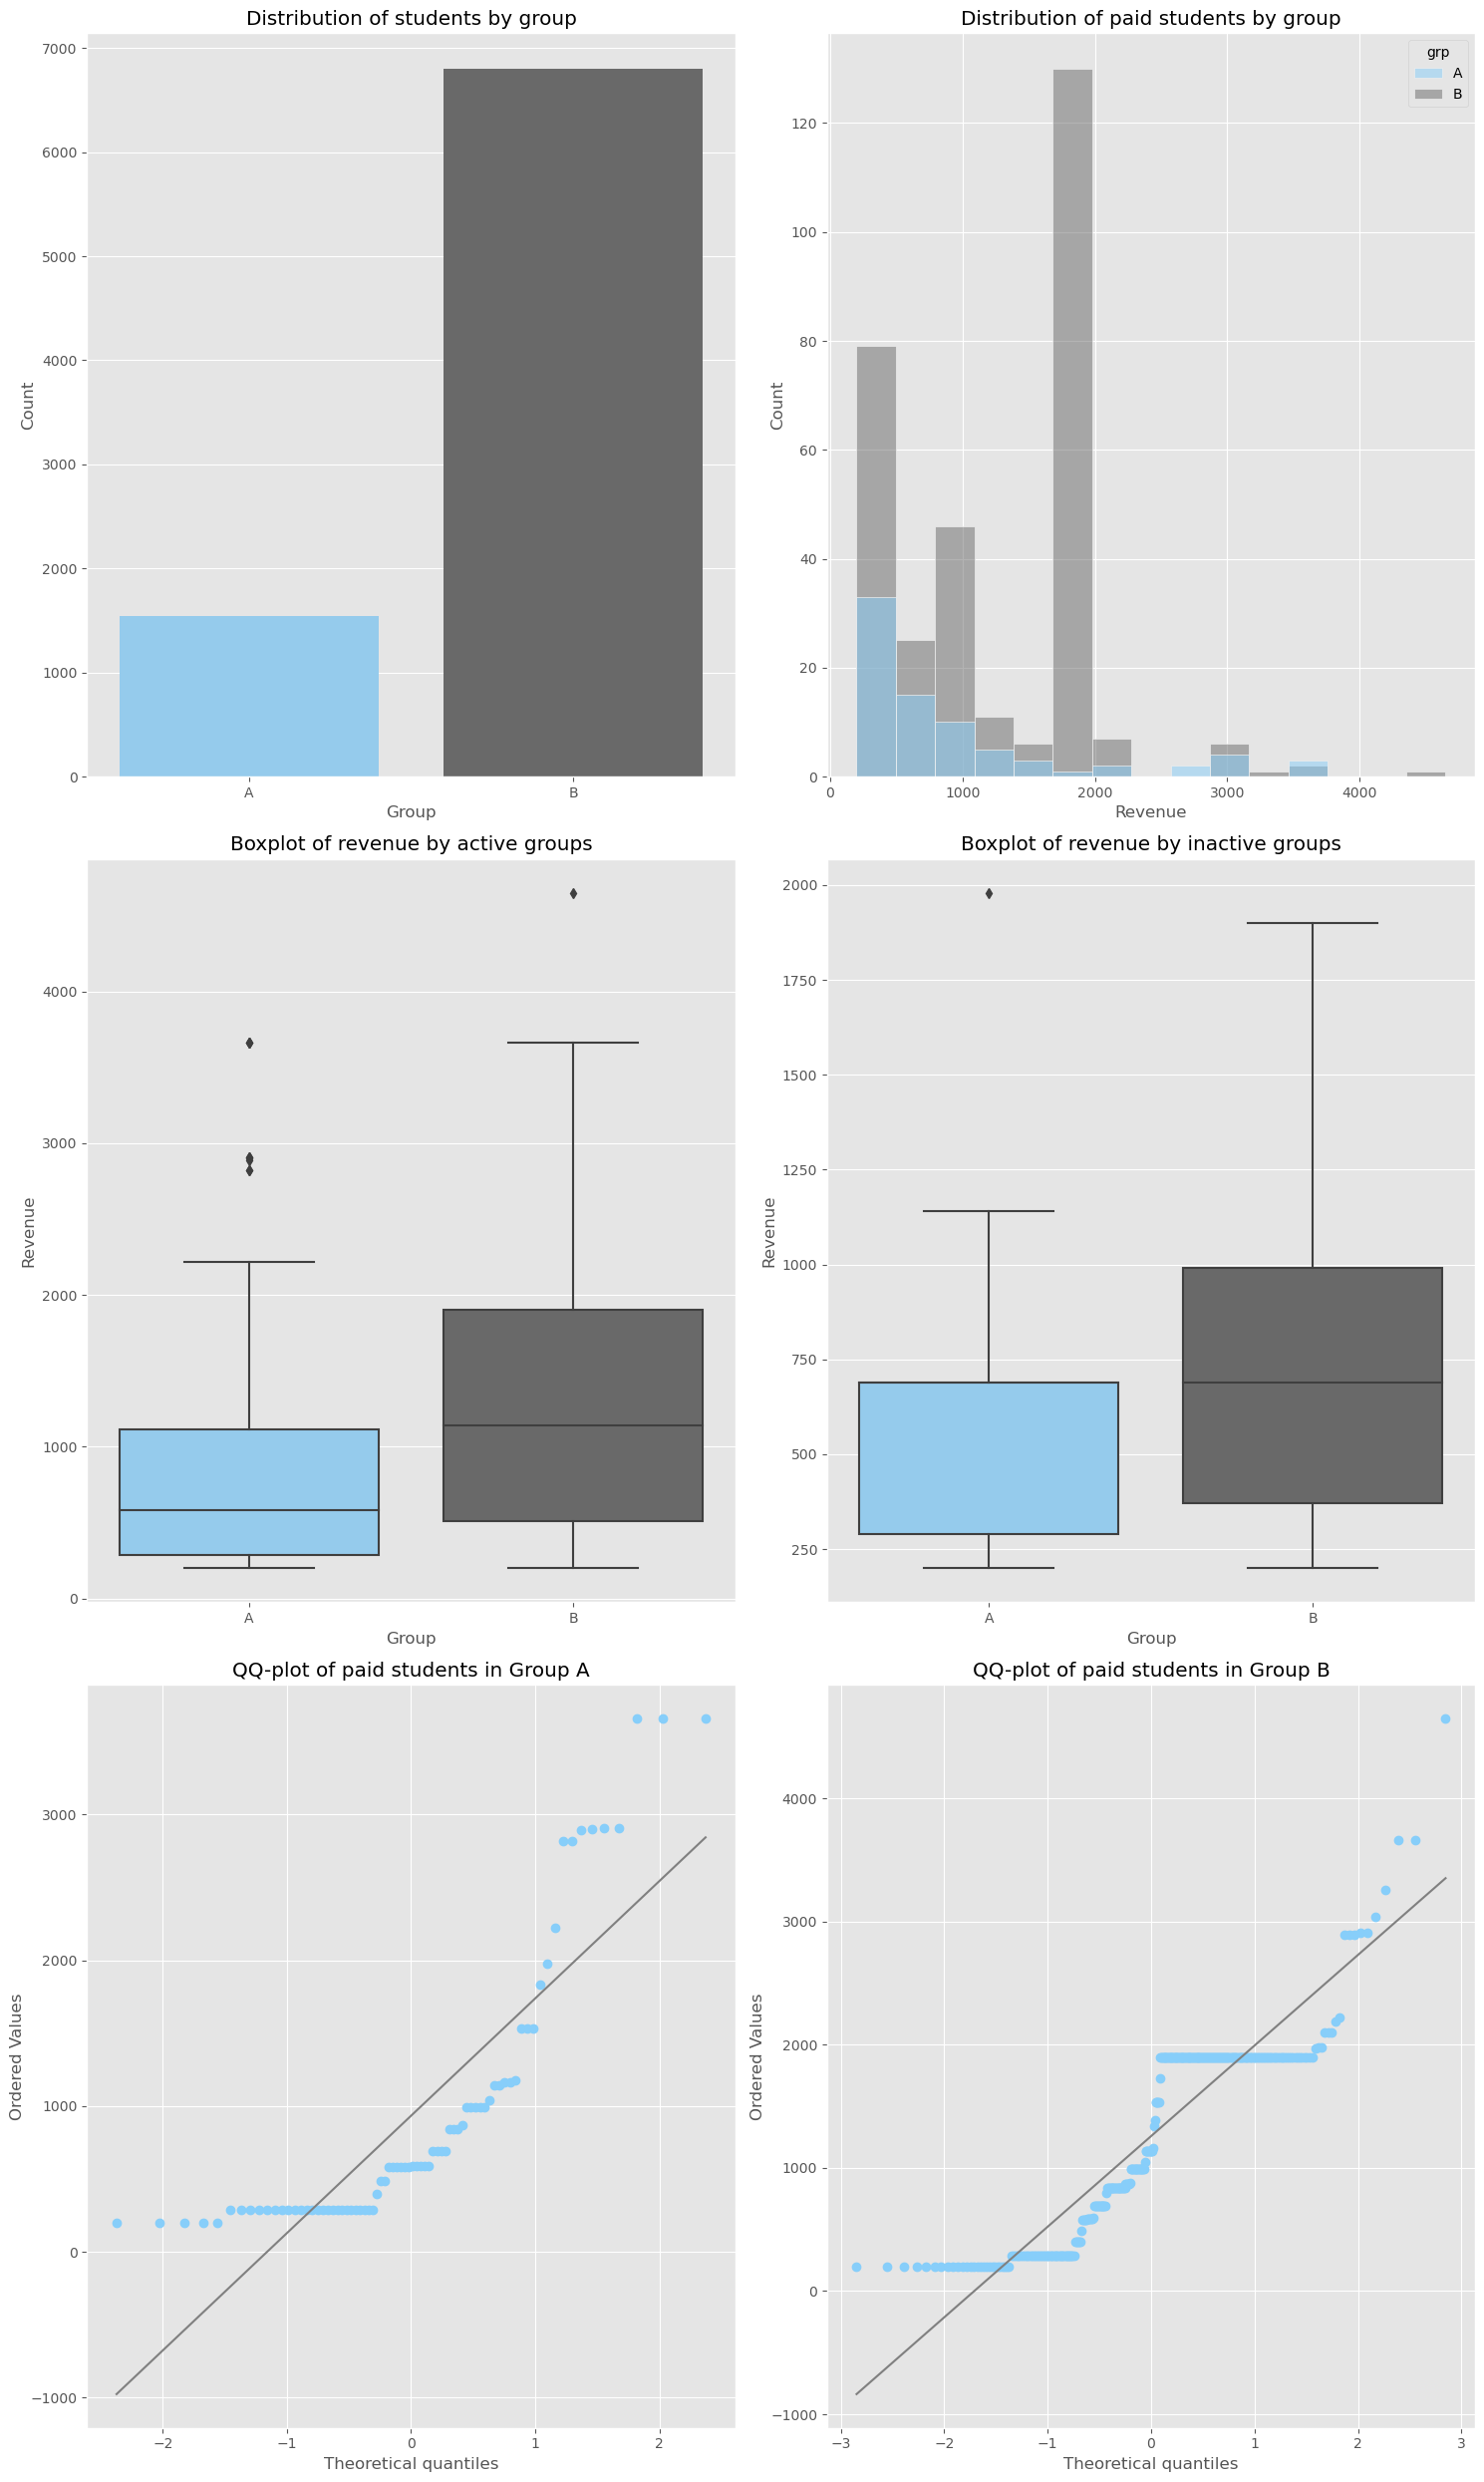

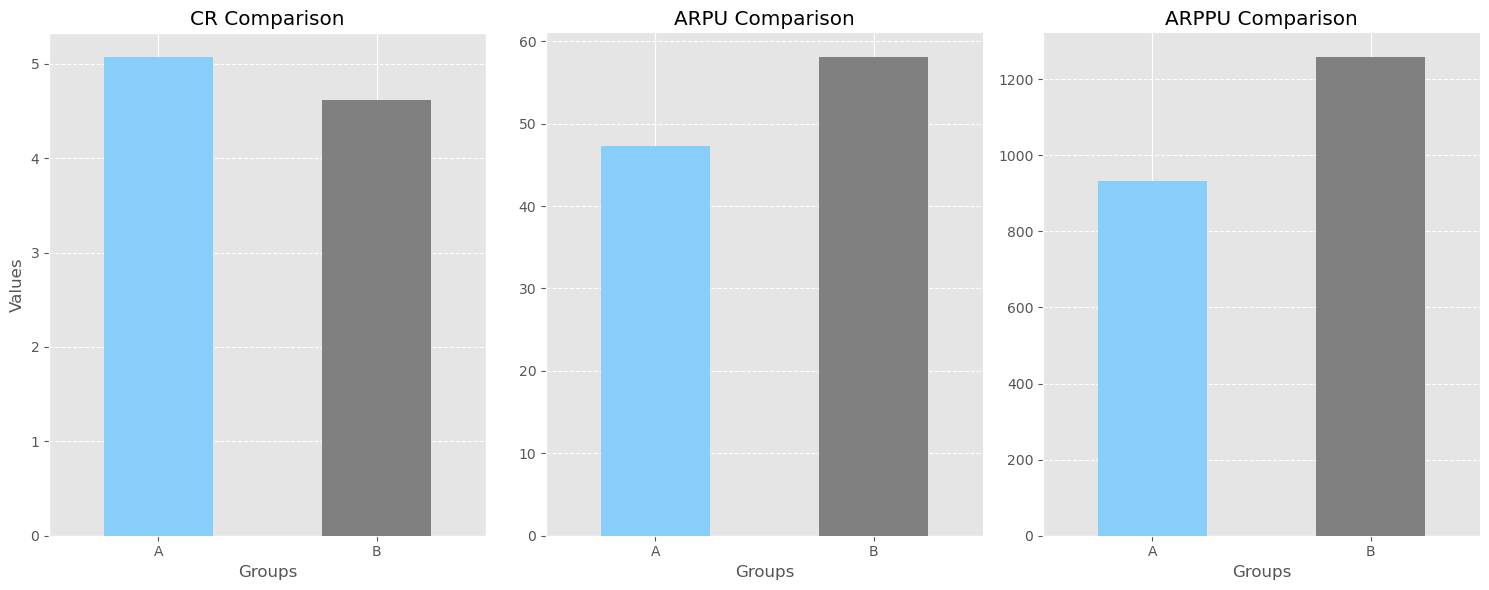

  group    CR   ARPU    ARPPU
0     A  5.07  47.35   933.59
1     B  4.62  58.06  1257.88
--------------------------------------------------------------------------------
Проверка метрик СR для групп А/Б критерием Хи-квадрат:


Таблица сопряженности для теста Хи-квадрат:
rev  False  True
grp             
A     1460    78
B     6489   314

Гипотезы:
H0: метрики CR в двух группах одинаковые
H1: метрики CR в двух группах различаются
Статистика Хи-квадрат: 0.5821513741106591
p-value: 0.44547028437158964
Доверительный интервал (критерий Хи-квадрат) для метрики CR: (-0.0166, 0.0075)
Гипотеза H0 не отвергается

--------------------------------------------------------------------------------
Проверка метрик ARPU и ARPPU для групп А/Б бутстрапом:




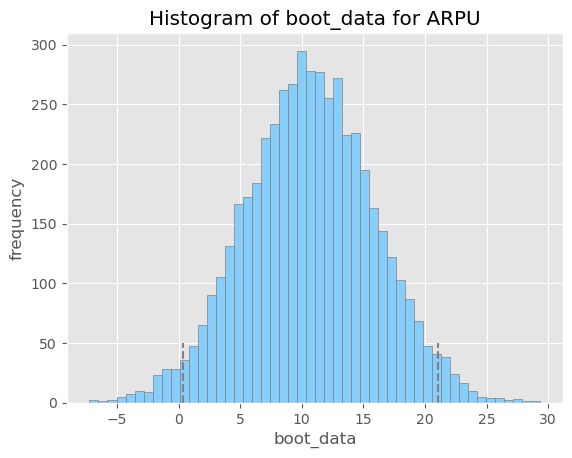

Гипотезы:
H0: метрики ARPU в двух группах одинаковые
H1: метрики ARPU в двух группах различаются
Доверительный интервал: [[ 0.33631553]
 [21.0256438 ]]
p-value: 0.04147412540276448
Гипотеза H0 отвергается в пользу альтернативной гипотезы H1



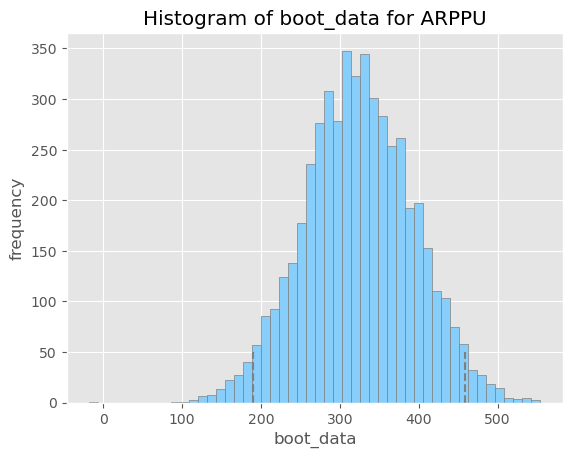

Гипотезы:
H0: метрики ARPPU в двух группах одинаковые
H1: метрики ARPPU в двух группах различаются
Доверительный интервал: [[189.89889586]
 [459.01028467]]
p-value: 2.5255335795103273e-06
Гипотеза H0 отвергается в пользу альтернативной гипотезы H1



In [89]:
# вызову функцию которая обновит данные по ссылке и вызовет ранее созданные функции из первого задания
get_update_and_analyze('https://drive.google.com/uc?id=1DY7PTk_Xes_Y4RbyELVvjw8VjamZH4zY', groups, active_studs, checks)

<a id='result_3'></a>
### Задача решена.

Функция обновила данные, пересчитала метрики и вывела по ним визуализацию - теперь по столбцу Missing student_id in groups значится 0. Это значит, что те 13 студентов, по которым группа ранее не была определена получили свою группу.

Ненормальность распределений осталась прежней, неоднородность (по-количеству студентов) в группах также наблюдается.

Как ранее я и предполагал, обновление не повлияло на выводы по метрикам и статистическим тестам. Изменения крайне незначительны и на выводы никак не влияют. Заметно улучшение показателя ARPPU.

Обновленные данные по результатам пересчета метрик и статистических тестов также позволяют отклонить нулевые гипотезы по метрикам ARPU и ARPPU, а по CR отклонить нулевую гипотезу также не получилось.

**Вывод! Доводы, изложенные выше, произведенные до обновления данных, справедливы и после обновления - значимых изменений не произошло.**